## Overall analysis plan

1. Use several llm to produce analysis of endocarditis data
2. Original data had 517 variables, in a meeting with Drs Mehaffey and Kawsara the number of variables was whittled down on clinical grounds to 323 variables
3. Plan to use measures of producing homogenous groups as measures of llm effectiveness
4. Describe variables with significant p values in groups produced
5. Use cosine similarity to assess if these various llms produced similar embeddings from data
6. Use ROC to find the 'best' model to predict Hospital Mortality
7. Assess stroke status

### After Discussion
<p style="color: blue;">
1. Use elbow method and 2 groups better chance for getting p values </p> <p style="color: red;"> completed </p>
<p style="color: blue;">2. Use random forest or similar to predict the 2 groups </p> <p style="color: red;"> completed </p>
<p style="color: blue;">3. Use shap scores to pick the variables to describe </p> <p style="color: red;"> completed </p>
<p style="color: blue;">4. Use these variables to predict mortality (in hospital) <p style="color: red;"> completed </p>
</p>

### Data loading and processing

1. In this step the csv file provided is loaded, the excel spreadsheet for hospital mortality with the approved variables is used to filter the stroke data for the variables marked with yes.
2. New variables for stroke,follow up time, pregnancy and vegatation created
3. Moderate to severe valve disease gathered into Moderate-severe valve disease or not
4. The number of rows and columns described
5. Missing data is listed



In [1]:
import pandas as pd

# Load the excel sheet
# Please replace 'your_excel_file.xlsx' with the actual Excel file name
# and 'sheet_name' with the actual sheet name that contains the data.
df_variables = pd.read_excel('Approved_Variable_Name.xlsx', sheet_name='Variables for In Hosp Mortality')

# Assuming that for each 'Variable' column there's an adjacent 'Yes/No' column
# We iterate over the pairs and collect variables marked 'Yes'
variables_yes = []
variables_no = []

# Initialize empty lists to store variable names
variables_yes = []
variables_no = []

# Iterate over the pairs of 'Variable' and 'Yes/No' columns
for var_col, yn_col in zip(df_variables.columns[::2], df_variables.columns[1::2]):
    # Filter variables marked 'Yes'
    yes_vars = df_variables.loc[df_variables[yn_col] == 'Yes', var_col].tolist()
    variables_yes.extend(yes_vars)
    
    # Filter variables marked 'No'
    no_vars = df_variables.loc[df_variables[yn_col] == 'No', var_col].tolist()
    variables_no.extend(no_vars)

# Add 'age' and 'BMI' to the variables_yes list if they are not already included
if 'age ' not in variables_yes:
    variables_yes.append('age ')
if 'BMI' not in variables_yes:
    variables_yes.append('BMI')
if 'Hospital death' not in variables_yes:
    variables_yes.append('Hospital death')


# Now, 'variables_yes' and 'variables_no' contain the appropriate variable names


# Now we have two lists: variables_yes and variables_no
# Next, we'll select the columns from df using variables_yes

# Load your main DataFrame
# Replace 'your_main_dataframe.csv' with the actual path to your DataFrame
df = pd.read_csv('Stroke 2.csv')

# Select columns from df that are marked 'Yes' in the Excel sheet
selected_columns_yes_df = df[variables_yes]

# Now selected_columns_yes_df contains only the columns listed as 'Yes' in the Excel sheet
# You can save this DataFrame to a new CSV if needed
#selected_columns_yes_df.to_csv('selected_columns_yes.csv', index=False)


/home/abbasali/tf-venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [2]:
# List columns that contain 'pre' or 'Pre'
columns_with_pre = [col for col in df.columns if 'pre echo' in col or 'Pre echo' in col]
print(columns_with_pre)

['pre echo- no sig valvular disease', 'pre echo- RV dys0unction ', 'pre echo- MR ', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI ', 'pre echo- pericardial e00usion', 'pre echo- MS ', 'pre echo- AS ', 'pre echo- TS', 'pre echo- ASD', 'Pre echo- pHTN', 'pre echo- RA mass', 'Pre echo- AV stenosis']


In [3]:
import pandas as pd

# Assuming df is your DataFrame
# Replace this with how you're actually reading or creating your DataFrame
# df = pd.read_csv('your_data.csv') or any other method

# Specified columns
#columns = ['pre echo- MR ', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI ']

# Dictionary to store levels for each column
levels = {}

for col in columns_with_pre:
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Get unique values (levels) in the column
        levels[col] = df[col].unique()
    else:
        print(f"Column '{col}' not found in DataFrame")

# Output the levels
for col, lvls in levels.items():
    print(f"Levels in '{col}': {lvls}")


Levels in 'pre echo- no sig valvular disease': [ 0. nan  1.]
Levels in 'pre echo- RV dys0unction ': ['0' nan 'mild' 'moderate']
Levels in 'pre echo- MR ': ['0' 'mild' 'sev' 'mod' nan 'trace' 'mild ' 'trivial']
Levels in 'Pre echo- TR': ['sev' 'mild' '0' 'mod' nan 'trace' 'mod ']
Levels in 'Pre echo- PR': ['0' nan 'mild' 'mod' 'sev']
Levels in 'pre echo- AI ': ['0' 'mild' 'sev' nan 'mod' 'trace']
Levels in 'pre echo- pericardial e00usion': [ 0. nan  1.]
Levels in 'pre echo- MS ': ['0' nan 'sev' 'mod']
Levels in 'pre echo- AS ': ['0' nan 'sev']
Levels in 'pre echo- TS': ['0' nan 'sev']
Levels in 'pre echo- ASD': [ 0. nan  1.]
Levels in 'Pre echo- pHTN': ['0' nan 'sev']
Levels in 'pre echo- RA mass': [ 0. nan  1.]
Levels in 'Pre echo- AV stenosis': [ 0. nan  1.]


In [4]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Replace this with how you're actually reading or creating your DataFrame
# df = pd.read_csv('your_data.csv') or any other method

# Original and new column mappings
column_mappings = {
    'pre echo- MR ': 'MR_mod_sev',
    'Pre echo- TR': 'TR_mod_sev',
    'Pre echo- PR': 'PR_mod_sev',
    'pre echo- AI ': 'AI_mod_sev'
}

for original, new in column_mappings.items():
    # Copying the values from the original column
    df[new] = df[original]

    # If original entry is NaN, use 'pre echo- no sig valvular disease' value
    df[new] = df[new].fillna(df['pre echo- no sig valvular disease'])

    # Set to 'Moderate to Severe' for specified conditions
    df[new] = df[new].apply(lambda x: 'Moderate to Severe' if x in ['sev', 'mod', 'moderate'] else x)

# Replace all 0 entries with 'None'
for new_col in column_mappings.values():
    df[new_col] = df[new_col].replace({0: 'None'})

# Print value counts for original and new columns
for col in column_mappings.keys():
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("\n")

for col in column_mappings.values():
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("\n")


Value counts for pre echo- MR :
pre echo- MR 
0          154
mild       133
sev         90
mod         34
trace       15
mild         1
trivial      1
Name: count, dtype: int64


Value counts for Pre echo- TR:
Pre echo- TR
sev      189
mild     116
mod       66
0         37
trace      6
mod        1
Name: count, dtype: int64


Value counts for Pre echo- PR:
Pre echo- PR
0       296
mild     53
mod       4
sev       3
Name: count, dtype: int64


Value counts for pre echo- AI :
pre echo- AI 
0        268
sev       50
mild      36
mod       18
trace      3
Name: count, dtype: int64


Value counts for MR_mod_sev:
MR_mod_sev
0                     154
mild                  133
Moderate to Severe    124
trace                  15
mild                    1
trivial                 1
1.0                     1
Name: count, dtype: int64


Value counts for TR_mod_sev:
TR_mod_sev
Moderate to Severe    255
mild                  116
0                      37
trace                   6
mod               

In [5]:
import pandas as pd

# Drop the specified original columns
df = df.drop(columns=['pre echo- MR ', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI '])

# Newly created columns
new_columns = ['MR_mod_sev', 'TR_mod_sev', 'PR_mod_sev', 'AI_mod_sev']

# Update entries in the new columns
for col in new_columns:
    df[col] = df[col].apply(lambda x: x if x == 'Moderate to Severe' else 'None')

# Print value counts for the new columns
for col in new_columns:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("\n")


Value counts for MR_mod_sev:
MR_mod_sev
None                  318
Moderate to Severe    124
Name: count, dtype: int64


Value counts for TR_mod_sev:
TR_mod_sev
Moderate to Severe    255
None                  187
Name: count, dtype: int64


Value counts for PR_mod_sev:
PR_mod_sev
None                  435
Moderate to Severe      7
Name: count, dtype: int64


Value counts for AI_mod_sev:
AI_mod_sev
None                  374
Moderate to Severe     68
Name: count, dtype: int64




In [6]:
# Columns to copy
columns_to_copy = ['MR_mod_sev', 'TR_mod_sev', 'PR_mod_sev', 'AI_mod_sev']

# Copying the columns
for col in columns_to_copy:
    selected_columns_yes_df[col] = df[col]

# Check the DataFrame to see the copied columns
print(selected_columns_yes_df.head())

   Pre op embolic stroke  Etiology- IVDU  Etiology- respiratory  \
0                      0               1                      0   
1                      0               0                      0   
2                      0               1                      0   
3                      0               0                      0   
4                      0               0                      0   

   Microbe- serratia  Microbe- strep sanguis  \
0                  0                       0   
1                  0                       0   
2                  0                       0   
3                  0                       0   
4                  0                       0   

   Microbe- stenotrephomonas maltophilia  Microbe- strep pneumo  \
0                                      0                      0   
1                                      0                      0   
2                                      0                      0   
3                                      0

In [7]:


# Get the dimensions of selected_columns_yes_df
selected_columns_df_dimensions = selected_columns_yes_df.shape

# Get the dimensions of df
original_df_dimensions = df.shape

# Calculate the difference in dimensions
# Since we're dealing with tuples, we need to calculate the difference in a tuple-compatible way
difference = tuple(a - b for a, b in zip(original_df_dimensions, selected_columns_df_dimensions))



# Print the dimensions
print("Number of rows and columns respectively in original dataFrame with selected variables Dimensions:", original_df_dimensions)
print("Number of rows and columns respectively in dataFrame with selected variables Dimensions:", selected_columns_df_dimensions)
print("Number of rows marked as no by investigators:", difference[1])
print("Number of rows marked as yes by investigators:", selected_columns_df_dimensions[1])

Number of rows and columns respectively in original dataFrame with selected variables Dimensions: (442, 517)
Number of rows and columns respectively in dataFrame with selected variables Dimensions: (442, 328)
Number of rows marked as no by investigators: 189
Number of rows marked as yes by investigators: 328


### Create new variable stoke status and follow_up_days

We used the days from stroke variable if present a new variable called Stroke status was marked yes otherwise marked no. For those with stroke number of days from stroke to surgery were tabulated and for those without stroke total inpatient length of stay computed and a new variable follow_up_days created.

In [8]:
# Correct any known issues with the column names
selected_columns_yes_df.columns = selected_columns_yes_df.columns.str.strip()

# Assuming 'df' and 'selected_columns_yes_df' are aligned (same index or have a common key to merge on)

# First, create the 'Stroke_Status' column based on the 'Days 0rom stroke to surgery' column in selected_columns_yes_df
selected_columns_yes_df['Stroke_Status'] = selected_columns_yes_df['Days 0rom stroke to surgery'].apply(
    lambda x: 'No Stroke' if pd.isna(x) else 'Stroke'
)

# Now, create the 'follow_up_days' column based on the 'Stroke_Status' column
# Ensure that the indexes of both DataFrames match or there is a common key to merge/join on
# If they are not aligned, you'll need to align them before this step, for example by using df.merge()
selected_columns_yes_df['follow_up_days'] = selected_columns_yes_df.apply(
    lambda row: row['Days 0rom stroke to surgery'] if row['Stroke_Status'] == 'Stroke' 
    else df.loc[row.name, 'Total LOS'], axis=1
)

import pandas as pd

# Load your CSV file into a DataFrame (replace 'your_data.csv' with your actual file path)
# selected_columns_yes_df = pd.read_csv('your_data.csv')

# Calculate the total number of rows in the DataFrame
total_rows = len(selected_columns_yes_df)

# Create a list to store the missing value information
missing_info = []

# Iterate through each column in the DataFrame
for column in selected_columns_yes_df.columns:
    # Count the number of missing values in the column
    missing_count = selected_columns_yes_df[column].isnull().sum()
    
    # Calculate the percent missing for the column
    percent_missing = (missing_count / total_rows) * 100
    
    # Append the information to the list if there are missing values
    if missing_count > 0:
        missing_info.append({'Variable': column, 'Missing Values': missing_count, 'Percent Missing': percent_missing})

# Create a DataFrame from the list
missing_info_selected_columns_yes_df = pd.DataFrame(missing_info)

# Sort the DataFrame in descending order by percent missing
missing_info_selected_columns_yes_df = missing_info_selected_columns_yes_df.sort_values(by='Percent Missing', ascending=False)

# Display the DataFrame with variables and their missing value information (excluding variables with 0 missing values)
print("                    Number of columns with % missing: \n \n", missing_info_selected_columns_yes_df[missing_info_selected_columns_yes_df['Missing Values'] > 0][['Variable', 'Percent Missing']])



                    Number of columns with % missing: 
 
                           Variable  Percent Missing
6                             pHTN        99.773756
10                        pregnant        96.832579
13     Days 0rom stroke to surgery        82.352941
18                         Post E0        26.470588
1                   Pre echo- pHTN        22.850679
19                    pre echo- TS        22.850679
5            Pre echo- AV stenosis        22.850679
3                pre echo- RA mass        22.850679
17                    pre echo- AS        22.624434
14                    pre echo- MS        22.398190
0         pre echo- RV dys0unction        22.398190
12  pre echo- pericardial e00usion        21.945701
8                     Pre echo- PR        19.457014
9                     pre echo- AI        15.158371
11                 Veg size 1-2 cm        14.705882
4                     Pre echo- TR         6.108597
2                     pre echo- MR         3.167421
16    

In [9]:
import pandas as pd

# Your code to define selected_columns_yes_df would go here
# For example:
# selected_columns_yes_df = pd.read_csv('your_file.csv') or any other method to create the DataFrame

# Define the function to apply the logic for creating the new 'pregnancy_status' variable
def determine_pregnancy_status(row):
    if not pd.isna(row['pregnant']):
        return 'pregnant woman'
    elif row['age'] < 40 and row['sex (M=1)'] == 0:
        return 'woman not pregnant'
    elif row['sex (M=1)'] == 0:
        return 'woman not eligible'
    elif row['sex (M=1)'] == 1:
        return 'men'
    else:
        return 'Unknown'  # This case should not happen, but it's a safeguard

# Apply the function to each row of the DataFrame
selected_columns_yes_df['pregnancy_status'] = selected_columns_yes_df.apply(determine_pregnancy_status, axis=1)

# Now selected_columns_yes_df has a new column 'pregnancy_status' with the defined categories


In [10]:
selected_columns_yes_df['pregnant'].value_counts()


pregnant
Vaginal delivery    6
Abortion            4
C section           2
Miscarriage         1
Pregnant            1
Name: count, dtype: int64

In [11]:
selected_columns_yes_df['pregnancy_status'].value_counts()

pregnancy_status
men                   195
woman not pregnant    175
woman not eligible     58
pregnant woman         14
Name: count, dtype: int64

In [12]:
import pandas as pd

# Assuming selected_columns_yes_df is your DataFrame and is already defined
# For example:
# selected_columns_yes_df = pd.read_csv('your_file.csv') or any other method to create the DataFrame

# Define the function to determine vegetation size
def determine_vegetation(row):
    if not pd.isna(row['Veg size <1 cm']) and row['Veg size <1 cm'] == 1:
        return 1
    elif not pd.isna(row['Veg size 1-2 cm']) and row['Veg size 1-2 cm'] == 1:
        return 2
    elif not pd.isna(row['Veg size >2 cm']) and row['Veg size >2 cm'] == 1:
        return 3
    else:
        return 'no vegetation'

# Apply the function to each row of the DataFrame
selected_columns_yes_df['Vegetation'] = selected_columns_yes_df.apply(determine_vegetation, axis=1)

# Now selected_columns_yes_df has a new column 'Vegetation' with the values assigned according to the logic provided


In [13]:
def determine_vegetation(row):
    if row['Veg size <1 cm'] == 1:
        return '1'
    elif row['Veg size 1-2 cm'] == 1:
        return '2'
    elif row['Veg size >2 cm'] == 1:
        return '3'
    else:
        return 'no vegetation'

# Apply the function to each row of the DataFrame
selected_columns_yes_df['Vegetation'] = selected_columns_yes_df.apply(determine_vegetation, axis=1)

# Convert 'Vegetation' to a categorical variable with specified levels
selected_columns_yes_df['Vegetation'] = pd.Categorical(
    selected_columns_yes_df['Vegetation'],
    categories=['no vegetation', '1', '2', '3'],
    ordered=True
)

# Recalculate the value counts for the 'Vegetation' variable
vegetation_count = selected_columns_yes_df['Vegetation'].value_counts(dropna=False)

# Print the value counts
print(f"Value counts for 'Vegetation':\n{vegetation_count}\n")


Value counts for 'Vegetation':
Vegetation
3                162
2                152
no vegetation     71
1                 57
Name: count, dtype: int64



In [14]:
selected_columns_yes_df['Vegetation'].value_counts()

Vegetation
3                162
2                152
no vegetation     71
1                 57
Name: count, dtype: int64

In [15]:
import pandas as pd

# Assuming selected_columns_yes_df is your DataFrame
# Replace this with how you're actually reading or creating your DataFrame
# selected_columns_yes_df = pd.read_csv('your_data.csv') or any other method

# Identify columns that start with 'Indication'
indication_columns = [col for col in selected_columns_yes_df.columns if col.startswith('Indication')]

# Filter for rows with no vegetation
# Make sure 'No' matches exactly what's in your 'Vegetation' column
no_vegetation_df = selected_columns_yes_df[selected_columns_yes_df['Vegetation'] == 'No']

# Count the occurrences of each indication when there's no vegetation
for col in indication_columns:
    print(f"Counts for {col} when there is no vegetation:")
    counts = no_vegetation_df[col].value_counts()
    if counts.empty:
        print("No entries")
    else:
        print(counts)
    print("\n")


Counts for Indication- annular abscess when there is no vegetation:
No entries


Counts for Indication- coronary artery disease when there is no vegetation:
No entries


Counts for Indications- heart block when there is no vegetation:
No entries


Counts for Indication- Arrhthmyia when there is no vegetation:
No entries


Counts for Indication- heart 0ailure (E0<55%, RV dys0unction) when there is no vegetation:
No entries


Counts for Indication- cardiogenic shock when there is no vegetation:
No entries


Counts for Indication- veg size when there is no vegetation:
No entries


Counts for Indication- Fungal etiology when there is no vegetation:
No entries


Counts for Indication- embolic phenomenon when there is no vegetation:
No entries


Counts for Indication- persistent blood cultures when there is no vegetation:
No entries


Counts for Indication- ventricular foreign body when there is no vegetation:
No entries


Counts for Indication- persistent sepsis when there is no vegetation:

In [16]:
# To print the number of missing values for the 'pregnant' and 'Vegetation' columns in the DataFrame

# Count missing values for 'pregnant'
missing_pregnant = selected_columns_yes_df['pregnant'].isna().sum()
missing_pregnancy_status = selected_columns_yes_df['pregnancy_status'].isna().sum() 


# Count missing values for 'Vegetation'
missing_vegetation = selected_columns_yes_df['Vegetation'].isna().sum()

# Print the counts
print(f"Missing values for 'pregnant': {missing_pregnant}")
print(f"Missing values for new variable 'pregnancy status': {missing_pregnancy_status}")

print(f"Missing values for 'Vegetation': {missing_vegetation}")



Missing values for 'pregnant': 428
Missing values for new variable 'pregnancy status': 0
Missing values for 'Vegetation': 0


In [17]:




# Create new categorical columns related to stroke status
selected_columns_yes_df['Stroke_Status'] = selected_columns_yes_df['Days 0rom stroke to surgery'].apply(lambda x: 'No Stroke' if pd.isna(x) else 'Stroke')
#selected_columns_yes_df['Days_From_Stroke_To_Surgery_Categorized'] = selected_columns_yes_df['Days 0rom stroke to surgery'].apply(lambda x: f"{x} days" if pd.notna(x) else 'No Stroke')

# Define continuous variables based on your knowledge of the dataset
continuous_vars = ['age', 'BMI', 'follow_up_days'
    # Add any other continuous variables as needed
]

# Define non-feature columns
non_feature_columns = ['Days 0rom stroke to surgery','Total LOS','Hospital death','pregnancy_status','Veg size <1 cm','Veg size 1-2 cm','Veg size >2 cm']

# Define categorical variables: all columns that are not in continuous_vars or non_feature_columns, plus the new stroke status columns
categorical_vars = [col for col in selected_columns_yes_df.columns if col not in continuous_vars + non_feature_columns]
categorical_vars.append('Stroke_Status')
#categorical_vars.append('Days_From_Stroke_To_Surgery_Categorized')

# Ensure the column names in continuous_vars and categorical_vars are present in the DataFrame
assert all(var in selected_columns_yes_df.columns for var in continuous_vars), "Some continuous variables are not in the DataFrame columns."
assert all(var in selected_columns_yes_df.columns for var in categorical_vars), "Some categorical variables are not in the DataFrame columns."

# Continue with the preprocessing pipelines for both numeric and categorical data
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())
#])

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent'))
#])

# Combine transformers into a preprocessor with ColumnTransformer
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, continuous_vars),
#        ('cat', categorical_transformer, categorical_vars)
#    ])


In [18]:


# Group by 'Stroke_Status' and calculate specific aggregations for 'follow_up_days'
grouped_summary_agg = selected_columns_yes_df.groupby('Stroke_Status')['follow_up_days'].agg(['count', 'mean', 'std', 'min', 'max'])

# Display the grouped summary with specific aggregations

print("                Follow up days grouped by stroke status: \n", grouped_summary_agg)


                Follow up days grouped by stroke status: 
                count       mean        std  min    max
Stroke_Status                                         
No Stroke        364  41.736264  17.943336  1.0  113.0
Stroke            78  12.833333  12.890565  1.0   67.0


### Percentage of Hospital and Follow up death

In [19]:
death_percentage = ((selected_columns_yes_df['Hospital death'] == 1).sum()/selected_columns_yes_df.shape[0])*100
print(f"Percentage of 'Hospital death' == 1: {death_percentage}")



Percentage of 'Hospital death' == 1: 4.751131221719457


In [20]:
import pandas as pd

# Assuming selected_columns_yes_df is already defined in your local environment

# Group by 'Stroke_Status' and calculate the death percentage for each group
death_percentage_by_stroke_status = selected_columns_yes_df.groupby('Stroke_Status')['Hospital death'].apply(
    lambda x: (x.sum() / x.count()) * 100
)

# Print the death percentage by Stroke Status
print("Death Percentage by Stroke Status:")
print(death_percentage_by_stroke_status)


Death Percentage by Stroke Status:
Stroke_Status
No Stroke    4.120879
Stroke       7.692308
Name: Hospital death, dtype: float64


### Describe how much of the data is zeros and how much is non zeros

In [21]:
import numpy as np
from scipy.sparse import issparse

# Check if selected_columns_yes_df_prep is a sparse matrix
if issparse(selected_columns_yes_df):
    total_elements = selected_columns_selected_columns_yes_df.shape[0] * selected_columns_selected_columns_yes_df.shape[1]  # Total number of elements
    non_zero_elements = selected_columns_selected_columns_yes_df.nnz  # Number of non-zero elements
else:
    total_elements = selected_columns_yes_df.size  # Total number of elements in the array
    non_zero_elements = np.count_nonzero(selected_columns_yes_df)

number_of_zeros = total_elements - non_zero_elements
non_zero_percentage = (non_zero_elements / total_elements) * 100
zero_percentage = 100-non_zero_percentage


print(f"Number of zeros in the array: {number_of_zeros}")
print(f"Number of cells with non-zeros in the array: {non_zero_elements}")
print(f"Percentage of cells with non-zeros in the array: {non_zero_percentage}%")
print(f"Percentage of cells with zeros in the array: {zero_percentage}%")

Number of zeros in the array: 124520
Number of cells with non-zeros in the array: 22224
Percentage of cells with non-zeros in the array: 15.144741863381125%
Percentage of cells with zeros in the array: 84.85525813661887%


In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2023-12-05 08:02:43.954084: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 08:02:44.033184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 08:02:44.033224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 08:02:44.033310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 08:02:44.130298: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


2023-12-05 08:02:46.258551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 08:02:46.409745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 08:02:46.409777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [23]:
#pick the 4070 gpu
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Use the first GPU (index 0)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')


In [24]:
# Define the function to create the sentence from a row
def create_sentence_from_row(row):
    sentence_parts = []
    for column, value in row.items():
        if value == 0:
            sentence_parts.append(f"no {column}")
        elif value == 1:
            sentence_parts.append(column)
        else:
            sentence_parts.append(f"{value} {column}")
    return ' '.join(sentence_parts)

# Apply the function to the first 3 rows of selected_columns_yes_df
first_3_sentences = selected_columns_yes_df.head(3).apply(create_sentence_from_row, axis=1)

# Print each sentence with a clear demarcation between rows
for index, sentence in enumerate(first_3_sentences, start=1):
    print(f"Row {index} Sentence:\n{sentence}\n" + "-"*50)  # 50 dashes as a demarcation line



Row 1 Sentence:
no Pre op embolic stroke Etiology- IVDU no Etiology- respiratory no Microbe- serratia no Microbe- strep sanguis no Microbe- stenotrephomonas maltophilia no Microbe- strep pneumo no Hx of cerebrovascular disease Acute pulm dysfunction no Comorb- liver disease no Comorb- heart 0ailure no Comorb- 0am hx CAD no Indication- annular abscess no Indication- coronary artery disease no Operation- AVr Operation- TVR (unspeci0ied) no Aortic root abscess no Operation- IABP placement no Laterality- L no preOP R0- septic emboli (neurologic) preOP R0- pneumonia no preOP R0- C di00 no PreOP RF- s/p STEMI no PreOP R0- sarcoilitis no PreOP R0-  RV dys0unction no PreOP RF- cerebral aneurysm no PreOP proc- spinal 0usion no PreOP proc- EGD C-scope GI Bleed no PreOP proc- Biopsy no PreOP proc- RTOR other service 25 age no Pre-op hemorrhagic stroke no Etiology- SSTI no Etiology-- osteomylitis no Microbe- Klebsiella no Microbe- strep viridans no Microbe- H. parain0luenza no Microbe- Granulicate

## Key step of the analysis

We now combine all the columns into a sentence similar to how an intern would present the case to the attending.

In [25]:
#combining all columns into a 'sentence'
#Key step in analysis
# Apply the function to create a 'sentence' for each row in the entire DataFrame
selected_columns_yes_df['combined'] = selected_columns_yes_df.apply(create_sentence_from_row, axis=1)

# Now, 'combined' column in selected_columns_yes_df contains the sentence for each row
selected_columns_yes_df['combined']

selected_columns_yes_df.shape

(442, 333)

In [26]:
import pandas as pd

# Assuming selected_columns_yes_df is your DataFrame and is already defined

# Set option to display the full content of a column without truncation
pd.set_option('display.max_colwidth', None)

# Display the entire entry for the first row in the 'combined' column
print(selected_columns_yes_df['combined'].head(1).to_string(index=False))


no Pre op embolic stroke Etiology- IVDU no Etiology- respiratory no Microbe- serratia no Microbe- strep sanguis no Microbe- stenotrephomonas maltophilia no Microbe- strep pneumo no Hx of cerebrovascular disease Acute pulm dysfunction no Comorb- liver disease no Comorb- heart 0ailure no Comorb- 0am hx CAD no Indication- annular abscess no Indication- coronary artery disease no Operation- AVr Operation- TVR (unspeci0ied) no Aortic root abscess no Operation- IABP placement no Laterality- L no preOP R0- septic emboli (neurologic) preOP R0- pneumonia no preOP R0- C di00 no PreOP RF- s/p STEMI no PreOP R0- sarcoilitis no PreOP R0-  RV dys0unction no PreOP RF- cerebral aneurysm no PreOP proc- spinal 0usion no PreOP proc- EGD C-scope GI Bleed no PreOP proc- Biopsy no PreOP proc- RTOR other service 25 age no Pre-op hemorrhagic stroke no Etiology- SSTI no Etiology-- osteomylitis no Microbe- Klebsiella no Microbe- strep viridans no Microbe- H. parain0luenza no Microbe- Granulicatella adiacens no 

In [27]:
print(list(selected_columns_yes_df.columns))

['Pre op embolic stroke', 'Etiology- IVDU', 'Etiology- respiratory', 'Microbe- serratia', 'Microbe- strep sanguis', 'Microbe- stenotrephomonas maltophilia', 'Microbe- strep pneumo', 'Hx of cerebrovascular disease', 'Acute pulm dysfunction', 'Comorb- liver disease', 'Comorb- heart 0ailure', 'Comorb- 0am hx CAD', 'Indication- annular abscess', 'Indication- coronary artery disease', 'Operation- AVr', 'Operation- TVR (unspeci0ied)', 'Aortic root abscess', 'Operation- IABP placement', 'Laterality- L', 'preOP R0- septic emboli (neurologic)', 'preOP R0- pneumonia', 'preOP R0- C di00', 'PreOP RF- s/p STEMI', 'PreOP R0- sarcoilitis', 'PreOP R0-  RV dys0unction', 'PreOP RF- cerebral aneurysm', 'PreOP proc- spinal 0usion', 'PreOP proc- EGD C-scope GI Bleed', 'PreOP proc- Biopsy', 'PreOP proc- RTOR other service', 'age', 'Pre-op hemorrhagic stroke', 'Etiology- SSTI', 'Etiology-- osteomylitis', 'Microbe- Klebsiella', 'Microbe- strep viridans', 'Microbe- H. parain0luenza', 'Microbe- Granulicatella a

In [28]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, \
                        DistilBertTokenizer, DistilBertModel, T5Tokenizer, T5EncoderModel, \
                        AutoTokenizer, AutoModel,XLNetModel, XLNetTokenizer

# Function to process text in batches and get embeddings (for large models like GatorTron)
def process_in_batches(tokenizer, model, texts, device, batch_size=10):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())  # CLS token embedding
        torch.cuda.empty_cache()
    return np.vstack(embeddings)
    
# Function to get embeddings from a model
def get_embeddings(tokenizer, model, texts, device):
    # Ensure the model is in evaluation mode
    model.eval()
    embeddings_list = []
    for text in texts:
        # Encode the text using the tokenizer
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        # Send encoded inputs to the device
        inputs = {key: val.to(device) for key, val in inputs.items()}
        # Get the model's output (no need to send labels)
        outputs = model(**inputs)
        # Extract the embeddings for the [CLS] token
        embeddings = outputs.last_hidden_state[:, 0, :]
        # Move embeddings back to CPU and convert to numpy
        embeddings_list.append(embeddings.detach().cpu().numpy())
    return np.vstack(embeddings_list)

# Your text data
combined_sentences = selected_columns_yes_df['combined'].tolist()

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define tokenizers and models including gatortron and gatortronS
tokenizers_and_models = {
    'bert': (BertTokenizer.from_pretrained('bert-base-uncased'), BertModel.from_pretrained('bert-base-uncased')),
    'roberta': (RobertaTokenizer.from_pretrained('roberta-base'), RobertaModel.from_pretrained('roberta-base')),
    'distilbert': (DistilBertTokenizer.from_pretrained('distilbert-base-uncased'), DistilBertModel.from_pretrained('distilbert-base-uncased')),
    't5': (T5Tokenizer.from_pretrained('t5-small'), T5EncoderModel.from_pretrained('t5-small')),
    'ernie': (AutoTokenizer.from_pretrained('nghuyong/ernie-2.0-en'), AutoModel.from_pretrained('nghuyong/ernie-2.0-en')),
    'gatortron': (AutoTokenizer.from_pretrained('UFNLP/gatortron-base'), AutoModel.from_pretrained('UFNLP/gatortron-base')),
    'gatortrons': (AutoTokenizer.from_pretrained('UFNLP/gatortronS'), AutoModel.from_pretrained('UFNLP/gatortronS')),
    'xlnet': (XLNetTokenizer.from_pretrained('xlnet-base-cased'), XLNetModel.from_pretrained('xlnet-base-cased'))
}

# Dictionary to hold all embeddings
all_embeddings = {}

# Process each model
for model_name, (tokenizer, model) in tokenizers_and_models.items():
    model.to(device)
    if model_name.startswith('gatortron'):  # For GatorTron models, use batch processing
        embeddings = process_in_batches(tokenizer, model, combined_sentences, device)
    else:  # For other models, process all texts at once
        embeddings = get_embeddings(tokenizer, model, combined_sentences, device)
    all_embeddings[model_name] = embeddings

# Print details of embeddings for each model
for model_name, embeddings in all_embeddings.items():
    print(f"Model: {model_name}")
    if embeddings is not None and len(embeddings) > 0:
        print("Embeddings Found")
        print(f"Shape: {embeddings.shape}")
        print(f"Data Type: {embeddings.dtype}")
        print("First few embeddings:", embeddings[:3])
    else:
        print("No embeddings found")
    print()  # Add an empty line for better readability

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model: bert
Embeddings Found
Shape: (442, 768)
Data Type: float32
First few embeddings: [[-0.5297837  -0.12304594 -0.21967128 ... -0.00151141  0.15091789
   0.5473397 ]
 [-0.52797294 -0.11238398 -0.24053793 ...  0.00215367  0.15079358
   0.5399173 ]
 [-0.51626676 -0.0907459  -0.17462784 ...  0.00528652  0.17931128
   0.512337  ]]

Model: roberta
Embeddings Found
Shape: (442, 768)
Data Type: float32
First few embeddings: [[-0.01700622  0.08115205 -0.01040618 ... -0.11502074 -0.03352011
  -0.00677348]
 [-0.01778895  0.07953996 -0.00835384 ... -0.11963447 -0.03296857
  -0.00491107]
 [-0.01526629  0.07834534 -0.00801679 ... -0.11350451 -0.03388206
  -0.00573877]]

Model: distilbert
Embeddings Found
Shape: (442, 768)
Data Type: float32
First few embeddings: [[-0.49991444 -0.00151219 -0.19816625 ...  0.13243854  0.34521905
   0.75041157]
 [-0.5084529  -0.01334948 -0.19091956 ...  0.12502246  0.34473705
   0.74185836]
 [-0.5119778  -0.00470386 -0.19243218 ...  0.14083692  0.3546161
   0.75082

#### Agglomorative clustering

Agglomerative Hierarchical Clustering: It is a technique used for unsupervised learning and is primarily used for cluster analysis. It aims to group similar data points together into clusters based on their similarities. Agglomerative Hierarchical Clustering: The output is a hierarchical representation of clusters, often visualized as a dendrogram. You can choose to cut the dendrogram at a certain height to form clusters. This method was unable to separate data into clusters.

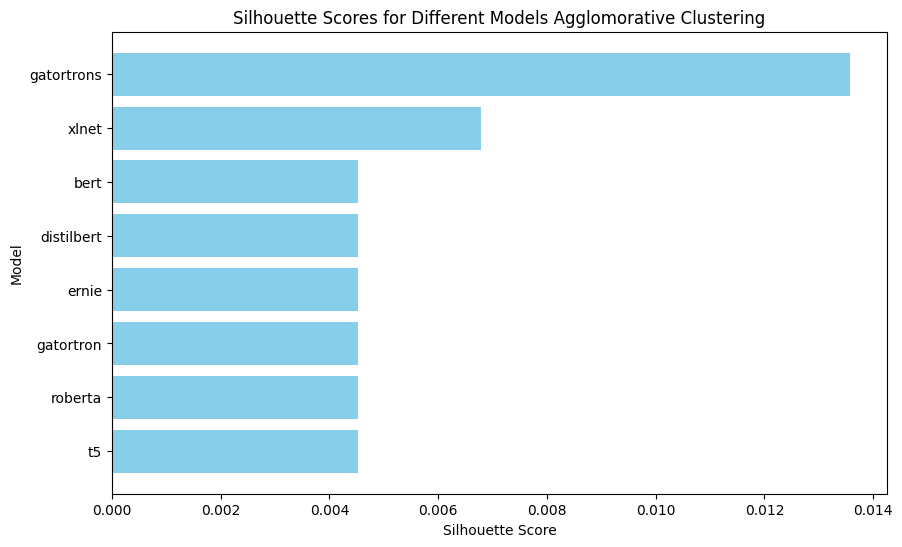

In [29]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, \
                        DistilBertTokenizer, DistilBertModel, T5Tokenizer, T5EncoderModel, \
                        AutoTokenizer, AutoModel, XLNetModel, XLNetTokenizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

# Assuming all_embeddings is a dictionary containing embeddings for each model

# Find the optimal number of clusters using the elbow method
def find_optimal_clusters(embeddings):
    linkage_matrix = ward(embeddings)
    distances = linkage_matrix[:, 2]
    last_distance = distances[0]
    best_score = 0
    optimal_clusters = 1

    for i, distance in enumerate(distances[1:], start=2):
        score = abs(last_distance - distance)
        if score > best_score:
            best_score = score
            optimal_clusters = i
        last_distance = distance

    return optimal_clusters

# Perform agglomerative hierarchical clustering with optimal clusters
cluster_data = {}
for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        optimal_clusters = find_optimal_clusters(embeddings)
        clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
        selected_columns_yes_df[f'{model_name}_cluster'] = clustering.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, selected_columns_yes_df[f'{model_name}_cluster'])
        cluster_data[model_name] = silhouette_avg

# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with silhouette scores
silhouette_df = pd.DataFrame(sorted_clusters, columns=['Model', 'Silhouette Score'])

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.barh(silhouette_df['Model'], silhouette_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores for Different Models Agglomorative Clustering')
plt.gca().invert_yaxis()
plt.show()


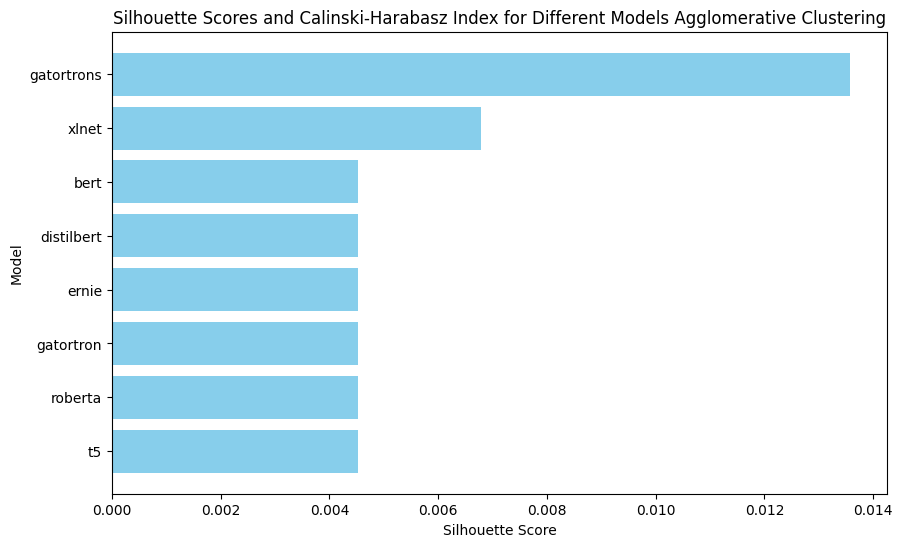

        Model  Silhouette Score  Calinski-Harabasz Index
0  gatortrons          0.013575             1.000000e+00
1       xlnet          0.006787             4.385150e+12
2        bert          0.004525             1.000000e+00
3  distilbert          0.004525             1.000000e+00
4       ernie          0.004525             1.000000e+00
5   gatortron          0.004525             1.000000e+00
6     roberta          0.004525             1.000000e+00
7          t5          0.004525             1.000000e+00


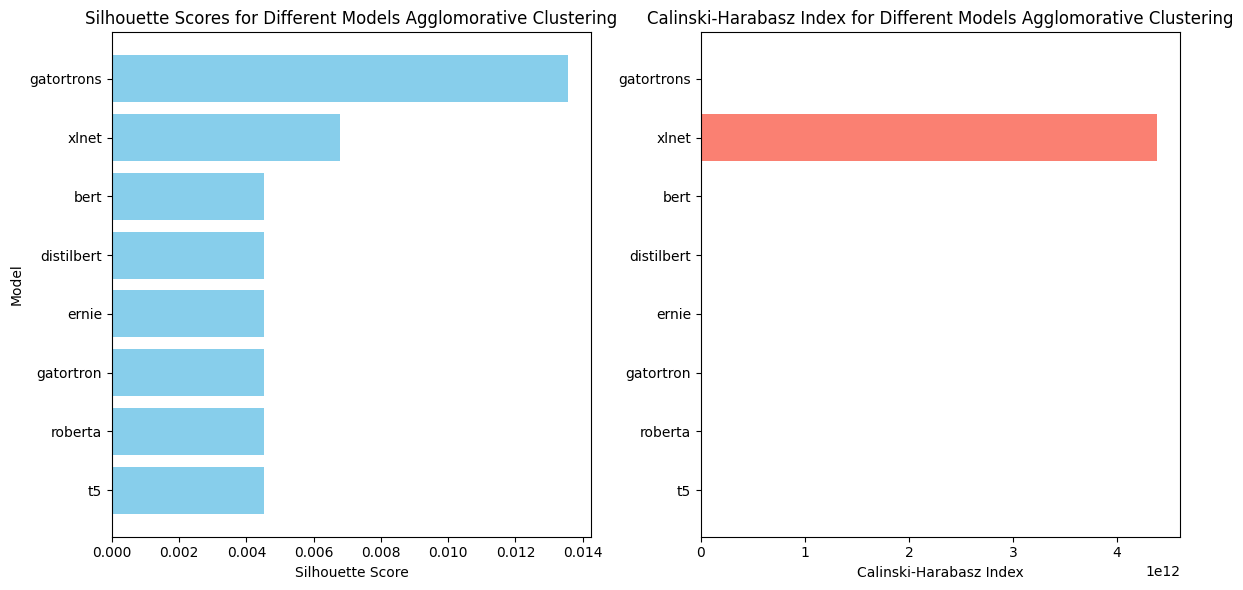

In [30]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, \
                        DistilBertTokenizer, DistilBertModel, T5Tokenizer, T5EncoderModel, \
                        AutoTokenizer, AutoModel, XLNetModel, XLNetTokenizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

# Assuming all_embeddings is a dictionary containing embeddings for each model

# Find the optimal number of clusters using the elbow method
def find_optimal_clusters(embeddings):
    linkage_matrix = ward(embeddings)
    distances = linkage_matrix[:, 2]
    last_distance = distances[0]
    best_score = 0
    optimal_clusters = 1

    for i, distance in enumerate(distances[1:], start=2):
        score = abs(last_distance - distance)
        if score > best_score:
            best_score = score
            optimal_clusters = i
        last_distance = distance

    return optimal_clusters

# Perform agglomerative hierarchical clustering with optimal clusters
cluster_data = {}
for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        optimal_clusters = find_optimal_clusters(embeddings)
        clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
        selected_columns_yes_df[f'{model_name}_cluster'] = clustering.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, selected_columns_yes_df[f'{model_name}_cluster'])
        cluster_data[model_name] = silhouette_avg

# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)




# Perform agglomerative hierarchical clustering with optimal clusters and calculate metrics
cluster_data = {}
ch_index_data = {}  # To store Calinski-Harabasz Index values

for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        optimal_clusters = find_optimal_clusters(embeddings)
        clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
        labels = clustering.fit_predict(embeddings)

        # Silhouette Score
        silhouette_avg = silhouette_score(embeddings, labels)
        cluster_data[model_name] = silhouette_avg

        # Calinski-Harabasz Index
        ch_score = calinski_harabasz_score(embeddings, labels)
        ch_index_data[model_name] = ch_score

# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)

# Sort CH Index scores in descending order
sorted_ch_index = sorted(ch_index_data.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with silhouette scores and CH Index scores
metrics_df = pd.DataFrame({
    'Model': [model for model, _ in sorted_clusters],
    'Silhouette Score': [score for _, score in sorted_clusters],
    'Calinski-Harabasz Index': [ch_index_data[model] for model, _ in sorted_clusters]
})

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Model'], metrics_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores and Calinski-Harabasz Index for Different Models Agglomerative Clustering')
plt.gca().invert_yaxis()
plt.show()

# Optionally, you can also display the DataFrame with the scores
print(metrics_df)

import matplotlib.pyplot as plt

# ... [Your existing code] ...

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores for Different Models Agglomorative Clustering')
plt.gca().invert_yaxis()

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color='salmon')
plt.xlabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Models Agglomorative Clustering')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



### Interpretation of Agglomorative Clustering

The bar chart depicts silhouette scores for various models' agglomerative clustering results. Overall, the values are very close to zero, which generally indicates poor clustering performance where cluster overlap is likely high and distinct clusters are not well-formed. Low silhouette scores suggest that the data points within each cluster are not very similar to each other, or that the separation between clusters is not clear. This might imply that the embeddings from these models do not have distinct, well-separated groupings for this particular dataset, or that agglomerative clustering may not be the most suitable method for this data.

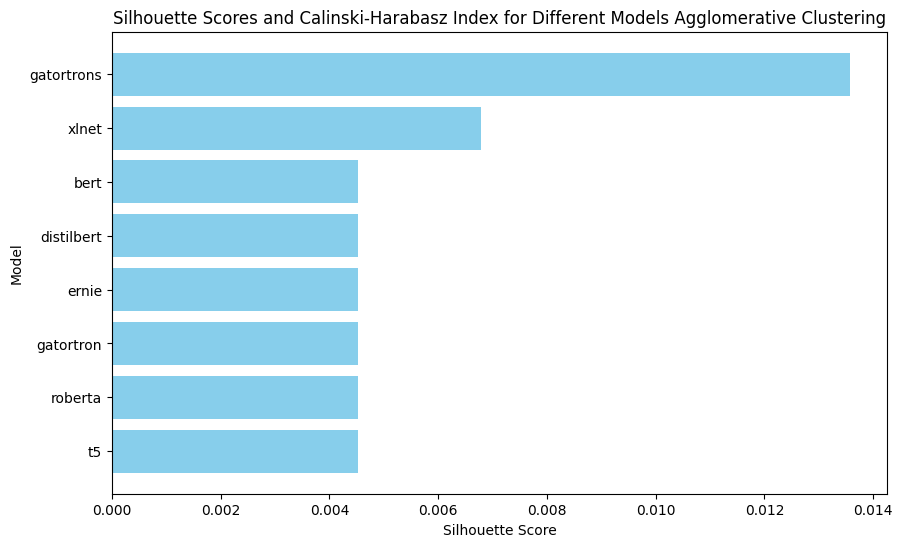

        Model  Silhouette Score  Calinski-Harabasz Index
0  gatortrons          0.013575             1.000000e+00
1       xlnet          0.006787             4.385150e+12
2        bert          0.004525             1.000000e+00
3  distilbert          0.004525             1.000000e+00
4       ernie          0.004525             1.000000e+00
5   gatortron          0.004525             1.000000e+00
6     roberta          0.004525             1.000000e+00
7          t5          0.004525             1.000000e+00


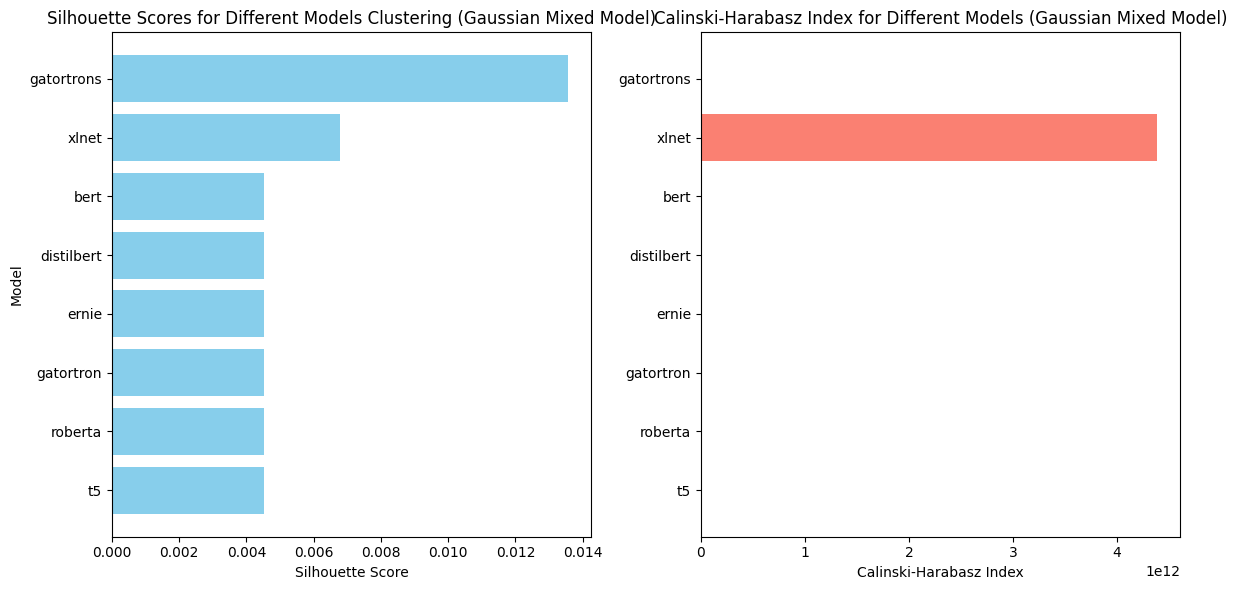

In [31]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Updated function to handle the potential LinAlgError by adjusting the 'reg_covar' parameter and reducing components for gmm clusters
def find_optimal_clusters_gmm(embeddings, max_clusters=10, reg_covar=1e-4):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, max_clusters)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    best_gmm = None

    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, reg_covar=reg_covar)
            try:
                gmm.fit(embeddings)
                bic.append(gmm.bic(embeddings))
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm
            except ValueError as e:
                print(f"Failed to fit GMM for {n_components} components with {cv_type} covariance: {e}")

    if best_gmm is None:
        print("Failed to find an optimal GMM configuration. Try increasing 'reg_covar' or reducing 'max_clusters'.")
    return best_gmm

# Perform Expectation-Maximization clustering using Gaussian Mixture Models
cluster_data = {}
# all_embeddings should be defined before this block
for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        best_gmm = find_optimal_clusters_gmm(embeddings)
        if best_gmm:
            cluster_labels = best_gmm.predict(embeddings)
            silhouette_avg = silhouette_score(embeddings, cluster_labels)
            cluster_data[model_name] = silhouette_avg
        else:
            print(f"Model {model_name} could not find an optimal GMM.")

# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)

# Perform agglomerative hierarchical clustering with optimal clusters and calculate metrics
cluster_data = {}
ch_index_data = {}  # To store Calinski-Harabasz Index values

for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        optimal_clusters = find_optimal_clusters(embeddings)
        clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
        labels = clustering.fit_predict(embeddings)

        # Silhouette Score
        silhouette_avg = silhouette_score(embeddings, labels)
        cluster_data[model_name] = silhouette_avg

        # Calinski-Harabasz Index
        ch_score = calinski_harabasz_score(embeddings, labels)
        ch_index_data[model_name] = ch_score

# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)

# Sort CH Index scores in descending order
sorted_ch_index = sorted(ch_index_data.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with silhouette scores and CH Index scores
metrics_df = pd.DataFrame({
    'Model': [model for model, _ in sorted_clusters],
    'Silhouette Score': [score for _, score in sorted_clusters],
    'Calinski-Harabasz Index': [ch_index_data[model] for model, _ in sorted_clusters]
})

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Model'], metrics_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores and Calinski-Harabasz Index for Different Models Agglomerative Clustering')
plt.gca().invert_yaxis()
plt.show()

# Optionally, you can also display the DataFrame with the scores
print(metrics_df)

import matplotlib.pyplot as plt

# ... [Your existing code] ...

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores for Different Models Clustering (Gaussian Mixed Model)')
plt.gca().invert_yaxis()

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color='salmon')
plt.xlabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Models (Gaussian Mixed Model)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



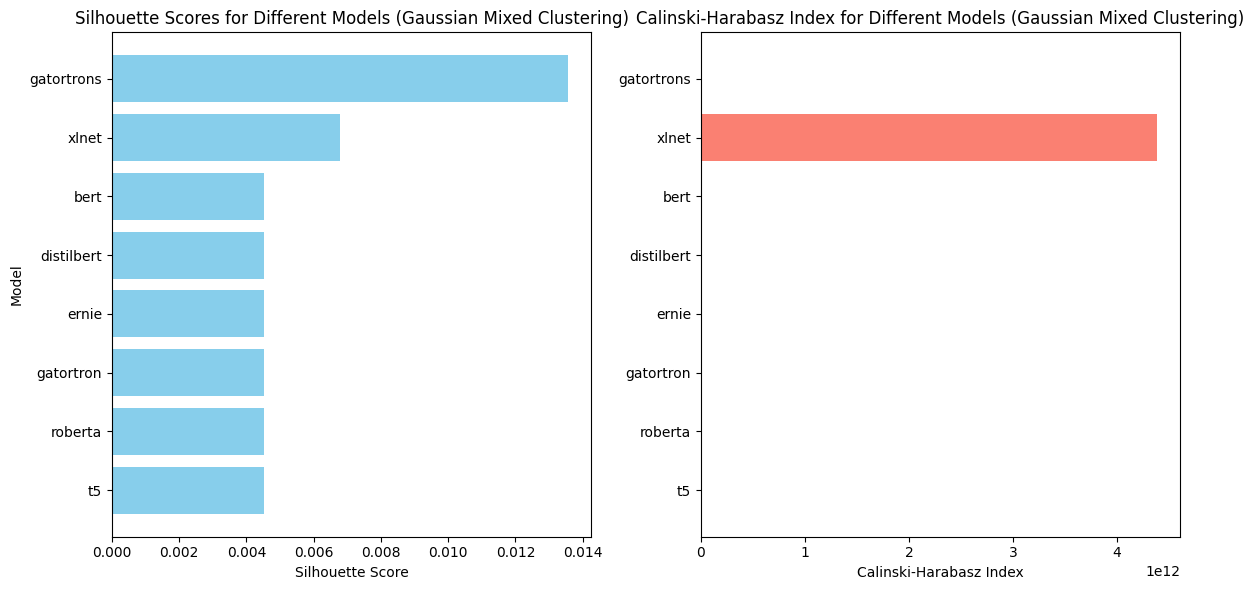

In [32]:


# Sort silhouette scores in descending order
sorted_clusters = sorted(cluster_data.items(), key=lambda x: x[1], reverse=True)

# Sort CH Index scores in descending order
sorted_ch_index = sorted(ch_index_data.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with silhouette scores and CH Index scores
metrics_df = pd.DataFrame({
    'Model': [model for model, _ in sorted_clusters],
    'Silhouette Score': [score for _, score in sorted_clusters],
    'Calinski-Harabasz Index': [ch_index_data[model] for model, _ in sorted_clusters]
})
# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Silhouette Score'], color='skyblue')
plt.xlabel('Silhouette Score')
plt.ylabel('Model')
plt.title('Silhouette Scores for Different Models (Gaussian Mixed Clustering)')
plt.gca().invert_yaxis()

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
plt.barh(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color='salmon')
plt.xlabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Models (Gaussian Mixed Clustering)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Interpretation of Gaussian Mixed Model Clustering

The bar chart showcases the silhouette scores for different models using a Gaussian Mixed Model clustering approach. The scores range between approximately 0.1 to 0.4, indicating moderate clustering quality—higher scores suggest better-defined clusters with greater separation. However, as the scores are not close to the maximum of 1, there's room for improvement in the cluster definitions, suggesting that some data points may still be closer to clusters to which they do not belong, or that the clusters have some degree of overlap.

### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm used in machine learning to identify clusters in data based on density. It groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

DBSCAN has three main concepts:

Core Points: In the context of DBSCAN, a core point is a point that has at least a minimum number of other points (min_samples) within a certain radius (eps). This radius can be thought of as a measure of density.

Border Points: A border point is not a core point itself (as it doesn't have enough neighbors to be considered a core point), but it lies within the radius of a core point.

Noise Points: Any point that is not a core point or a border point is considered noise by DBSCAN. That is, it's not in a dense region.

The process of DBSCAN clustering goes as follows:

The algorithm starts with an arbitrary point and retrieves all points density-reachable from the initial point based on eps and min_samples.
If the point is a core point, the points density-reachable from it are all added to the same cluster.
This process continues until all points that are density-connected are found and added to the cluster.
A new unvisited point is then retrieved and processed, leading to the discovery of a further cluster or noise.
This process iterates until all points are classified into different clusters or marked as noise.
The key advantages of DBSCAN are:

It does not require one to specify the number of clusters a priori.
It can find arbitrarily shaped clusters.
It has a notion of noise, and thus, it is robust to outliers.
However, DBSCAN's effectiveness is heavily dependent on the settings of eps and min_samples:

If eps is chosen too small, a large part of the data will not be clustered—it will be considered noise.
If eps is set too high, clusters will merge, and the majority of objects will be in the same cluster.
The min_samples parameter similarly affects the sensitivity to noise: the larger min_samples, the more points will be considered noise.
Choosing these parameters requires understanding of the data and possibly some trial and error or heuristic methods. It can be useful to visualize the data or the distance distribution of the points to determine suitable values.

Estimated number of clusters for bert: 2
Estimated number of noise points for bert: 14
bert Silhouette Score: 0.2458469271659851
Estimated number of clusters for roberta: 1
Estimated number of noise points for roberta: 0
roberta Silhouette Score cannot be calculated for a single cluster.
Estimated number of clusters for distilbert: 1
Estimated number of noise points for distilbert: 0
distilbert Silhouette Score cannot be calculated for a single cluster.
Estimated number of clusters for t5: 2
Estimated number of noise points for t5: 0
t5 Silhouette Score: 0.9614770412445068
Estimated number of clusters for ernie: 3
Estimated number of noise points for ernie: 7
ernie Silhouette Score: 0.4947623312473297
Estimated number of clusters for gatortron: 9
Estimated number of noise points for gatortron: 202
gatortron Silhouette Score: 0.060052528977394104
Estimated number of clusters for gatortrons: 7
Estimated number of noise points for gatortrons: 363
gatortrons Silhouette Score: -0.1726083159

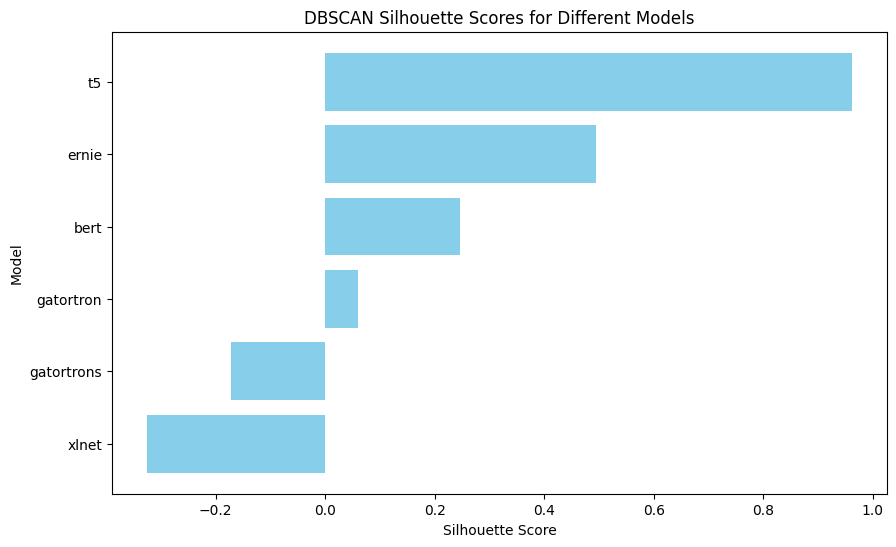

In [33]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward

# Function to apply DBSCAN clustering and calculate silhouette scores
def dbscan_clustering_and_silhouette_analysis(embeddings_dict, dataframe):
    dbscan_cluster_data = {}
    for model_name, embeddings in embeddings_dict.items():
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings)
        labels = dbscan.labels_

        # Number of clusters in labels, ignoring noise if present
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print(f'Estimated number of clusters for {model_name}: {n_clusters_}')
        print(f'Estimated number of noise points for {model_name}: {n_noise_}')

        # Calculate silhouette score for the clustering, ignoring noise if present
        if n_clusters_ > 1:
            silhouette_avg = silhouette_score(embeddings, labels)
            print(f"{model_name} Silhouette Score: {silhouette_avg}")
            dbscan_cluster_data[model_name] = silhouette_avg
        else:
            print(f"{model_name} Silhouette Score cannot be calculated for a single cluster.")
            dbscan_cluster_data[model_name] = None

        # Add clustering labels to the original dataframe
        dataframe[f'{model_name}_dbscan_group'] = labels

    # Sort silhouette scores in descending order and handle None values
    sorted_dbscan_clusters = sorted([(model, score if score is not None else -1) 
                                     for model, score in dbscan_cluster_data.items()], 
                                    key=lambda x: x[1], reverse=True)

    # Create a DataFrame with silhouette scores
    silhouette_df = pd.DataFrame(sorted_dbscan_clusters, columns=['Model', 'Silhouette Score'])

    # Replace -1 with 'N/A' for models that could not have silhouette score calculated
    silhouette_df['Silhouette Score'] = silhouette_df['Silhouette Score'].replace(-1, 'N/A')

    return silhouette_df

# Function to plot silhouette scores
def plot_silhouette_scores(silhouette_df):
    plt.figure(figsize=(10, 6))
    # Filter out 'N/A' values for plotting
    valid_scores_df = silhouette_df[silhouette_df['Silhouette Score'] != 'N/A']
    y_pos = np.arange(len(valid_scores_df['Model']))
    plt.barh(y_pos, valid_scores_df['Silhouette Score'], color='skyblue')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Model')
    plt.title('DBSCAN Silhouette Scores for Different Models')
    plt.yticks(y_pos, valid_scores_df['Model'])
    plt.gca().invert_yaxis()
    plt.show()

# Assuming all_embeddings is your dictionary of embeddings from different models
# And selected_columns_yes_df is the DataFrame to which you want to add the DBSCAN cluster labels

# Apply the DBSCAN clustering and silhouette analysis function to the embeddings
dbscan_silhouette_df = dbscan_clustering_and_silhouette_analysis(all_embeddings, selected_columns_yes_df)
plot_silhouette_scores(dbscan_silhouette_df)


### Interpretation of DBSCAN clustering

The bar chart illustrates the silhouette scores for various models using DBSCAN clustering. Scores range from below zero to around 0.6, which indicates varying levels of clustering quality. The negative values suggest that some clusters may have been incorrectly assigned, or that data points are closer to neighboring clusters than to their own. The positive scores, particularly those closer to 0.6, suggest more appropriate clustering with better-defined cluster separation. However, no model achieves a score close to 1, which would indicate very distinct, well-separated clusters with high internal consistency.

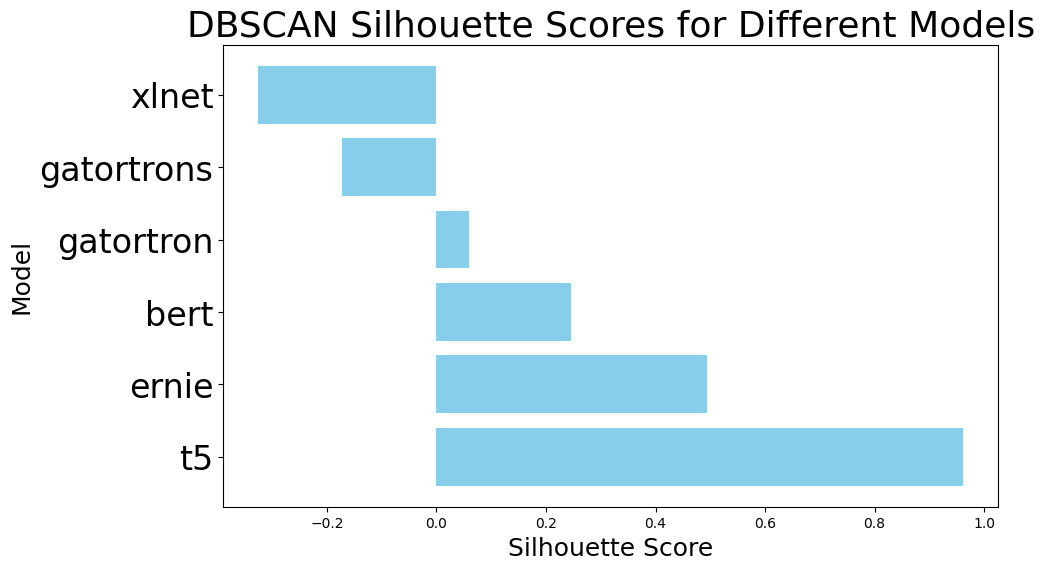

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
data = {
    'Model': ['bert', 'roberta', 'distilbert', 't5', 'ernie', 'gatortron', 'gatortrons', 'xlnet'],
    'Silhouette Score': [0.2458469271659851, None, None, 0.9614770412445068, 0.4947623312473297, 0.060052528977394104, -0.17260831594467163, -0.3253207802772522]
}

# Create a DataFrame from the data
silhouette_df = pd.DataFrame(data)

# Filter out models with None silhouette scores
silhouette_df = silhouette_df.dropna(subset=['Silhouette Score'])

# Sort the DataFrame by silhouette scores in descending order
silhouette_df = silhouette_df.sort_values(by='Silhouette Score', ascending=False)

# Function to plot silhouette scores
def plot_silhouette_scores(silhouette_df):
    plt.figure(figsize=(10, 6))
    # Filter out 'N/A' values for plotting
    valid_scores_df = silhouette_df[silhouette_df['Silhouette Score'] != 'N/A']
    valid_scores_df = valid_scores_df.sort_values(by='Silhouette Score')  # Sort by Silhouette Score
    y_pos = np.arange(len(valid_scores_df['Model']))
    plt.barh(y_pos, valid_scores_df['Silhouette Score'], color='skyblue')
    plt.xlabel('Silhouette Score', fontsize=18)  # Set font size for x-axis label
    plt.ylabel('Model', fontsize=18)  # Set font size for y-axis label
    plt.title('DBSCAN Silhouette Scores for Different Models', fontsize=26)  # Set font size for title
    plt.yticks(y_pos, valid_scores_df['Model'], fontsize=24)  # Set font size for y-axis ticks
    plt.gca().invert_yaxis()
    plt.show()
# Plot silhouette scores
plot_silhouette_scores(silhouette_df)





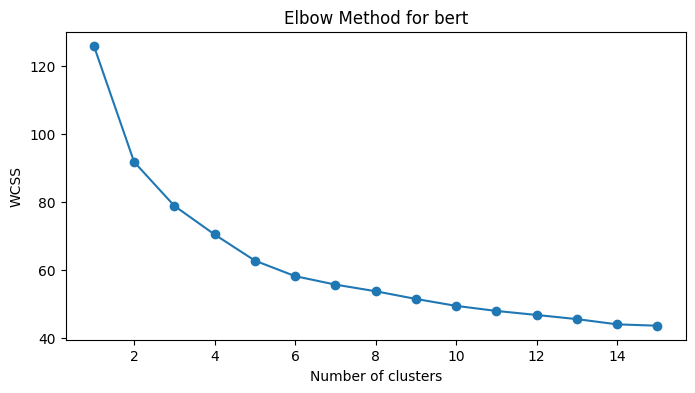

bert Silhouette Score with 13 Clusters: 0.21818997
bert Calinski-Harabasz Index with 13 Clusters: 63.194014883554146


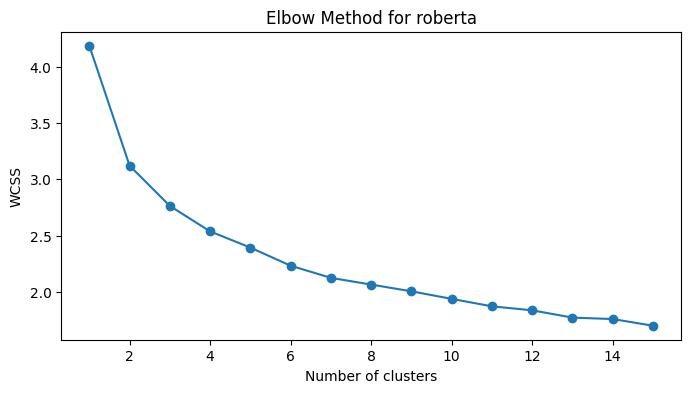

roberta Silhouette Score with 14 Clusters: 0.14129838
roberta Calinski-Harabasz Index with 14 Clusters: 45.51696983088924


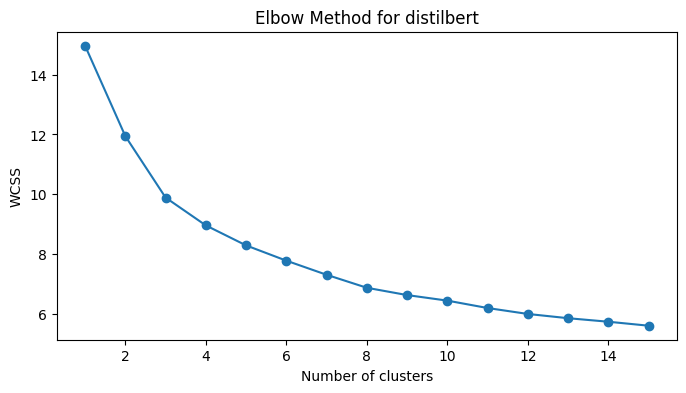

distilbert Silhouette Score with 10 Clusters: 0.18073545
distilbert Calinski-Harabasz Index with 10 Clusters: 63.53402831302903


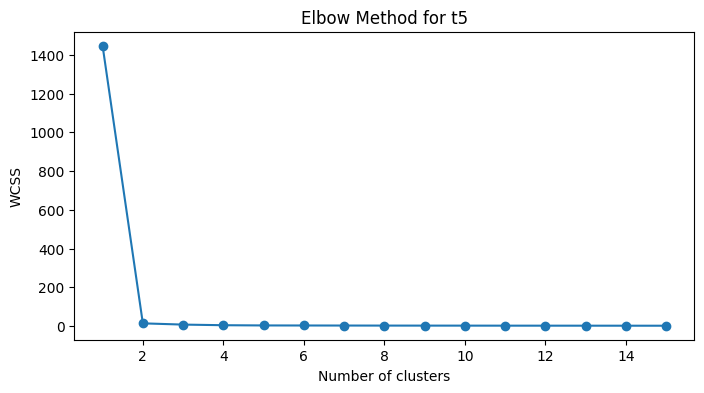

t5 Silhouette Score with 10 Clusters: 0.34458414
t5 Calinski-Harabasz Index with 10 Clusters: 30429.26369703649


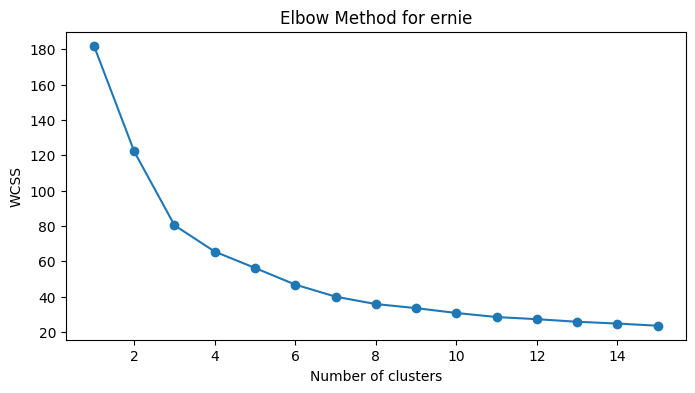

ernie Silhouette Score with 9 Clusters: 0.46076915
ernie Calinski-Harabasz Index with 9 Clusters: 240.65469197132452


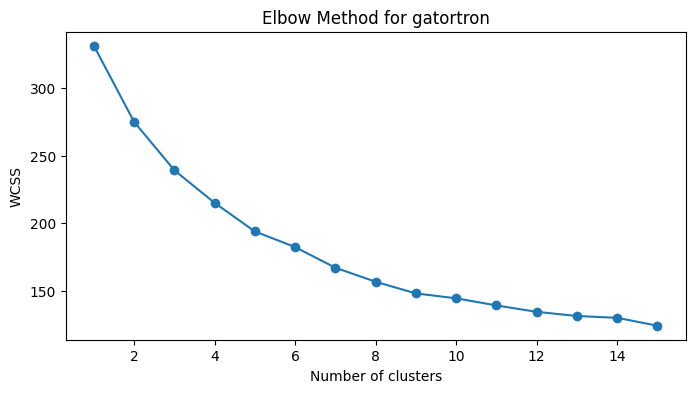

gatortron Silhouette Score with 14 Clusters: 0.21769845
gatortron Calinski-Harabasz Index with 14 Clusters: 51.14249288035105


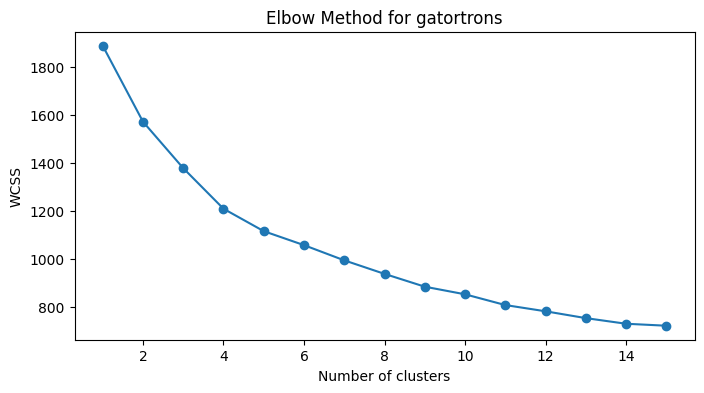

gatortrons Silhouette Score with 10 Clusters: 0.20365685
gatortrons Calinski-Harabasz Index with 10 Clusters: 58.58579904357416


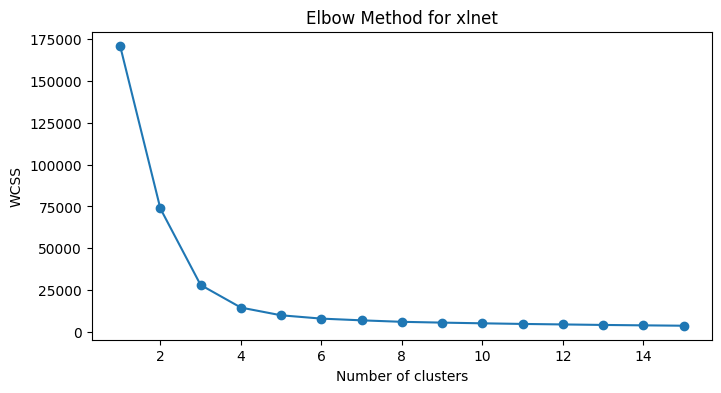

xlnet Silhouette Score with 12 Clusters: 0.43551654
xlnet Calinski-Harabasz Index with 12 Clusters: 1425.0255266102595


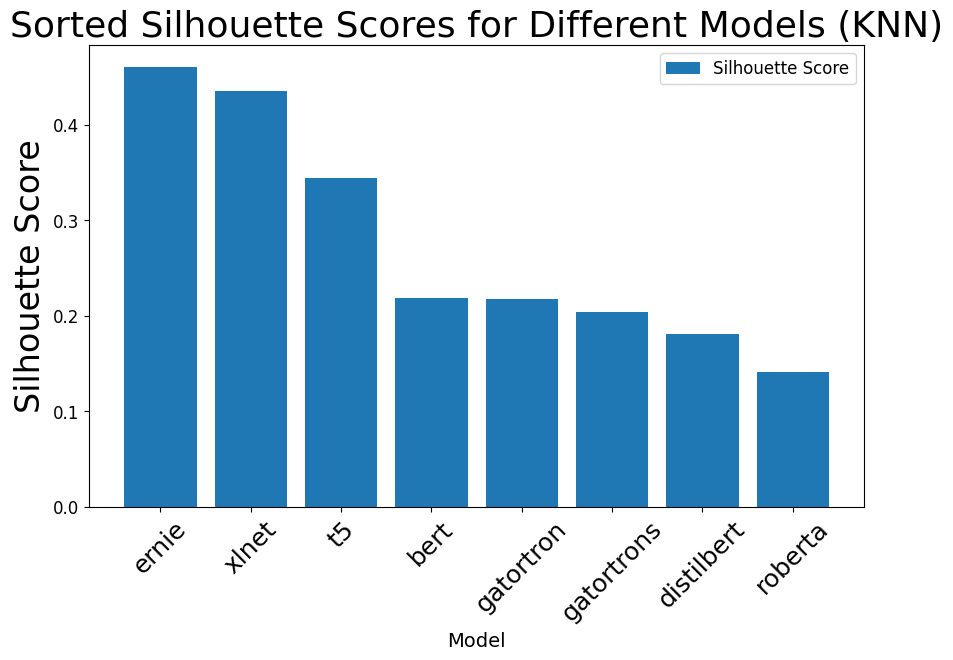

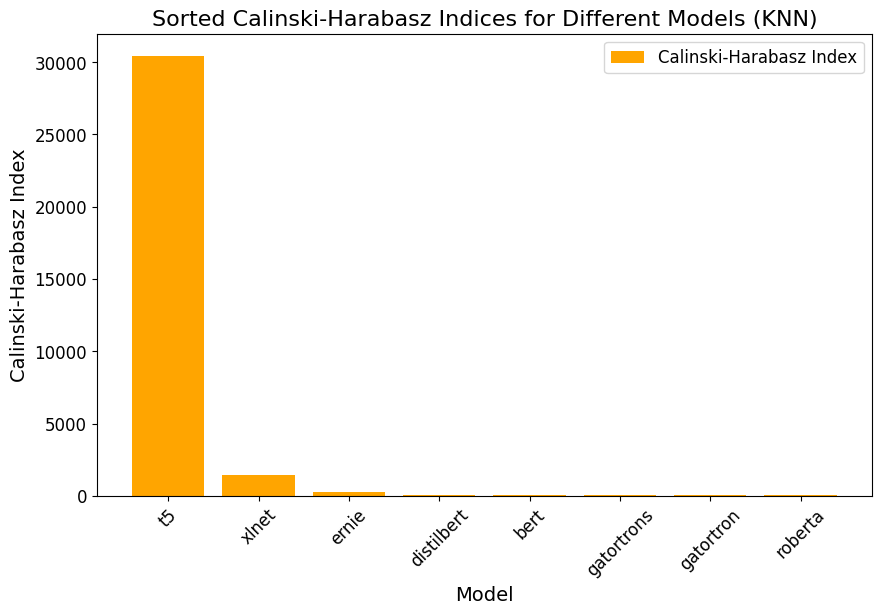

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the optimal number of clusters using the elbow method and silhouette scores
def elbow_method_and_silhouette_score(embeddings, model_name, max_clusters=None):
    # Check if there are enough samples to form clusters
    if embeddings.shape[0] < 2:
        print(f"Not enough samples to form clusters for {model_name}.")
        return None, None
    
    # Set the maximum number of clusters
    if max_clusters is None:
        max_clusters = min(embeddings.shape[0] - 1, 15)
    
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title(f'Elbow Method for {model_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    if len(wcss) > 1:
        second_derivatives = np.diff(wcss, n=2)
        optimal_n_clusters = np.argmin(second_derivatives) + 2
    else:
        optimal_n_clusters = 1
    
    if optimal_n_clusters == 1:
        print(f"Only one cluster determined for {model_name}. Cannot calculate silhouette score.")
        return None, None

    kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, init='k-means++', random_state=0, n_init=10)
    kmeans_optimal.fit(embeddings)
    silhouette_score_value = silhouette_score(embeddings, kmeans_optimal.labels_)

    # Calculate Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(embeddings, kmeans_optimal.labels_)

    print(f"{model_name} Silhouette Score with {optimal_n_clusters} Clusters:", silhouette_score_value)
    print(f"{model_name} Calinski-Harabasz Index with {optimal_n_clusters} Clusters:", ch_index)

    return silhouette_score_value, ch_index

# Assuming all_embeddings is a dictionary with model names as keys and their corresponding embeddings as values
silhouette_scores = {}
calinski_harabasz_indices = {}

for model_name, embeddings in all_embeddings.items():
    if embeddings is not None and len(embeddings) > 0:
        silhouette_score_value, ch_index = elbow_method_and_silhouette_score(np.array(embeddings), model_name)
        silhouette_scores[model_name] = silhouette_score_value
        calinski_harabasz_indices[model_name] = ch_index

# Sort models by their silhouette score in descending order
sorted_models_silhouette = sorted(silhouette_scores, key=silhouette_scores.get, reverse=True)

# Plot sorted silhouette scores
plt.figure(figsize=(10, 6))
sorted_silhouette_scores = [silhouette_scores[model] for model in sorted_models_silhouette]
plt.bar(sorted_models_silhouette, sorted_silhouette_scores, label='Silhouette Score')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=24)
plt.title('Sorted Silhouette Scores for Different Models (KNN)', fontsize=26)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Sort models by their Calinski-Harabasz index in descending order
sorted_models_ch = sorted(calinski_harabasz_indices, key=calinski_harabasz_indices.get, reverse=True)

# Plot sorted Calinski-Harabasz indices
plt.figure(figsize=(10, 6))
sorted_ch_scores = [calinski_harabasz_indices[model] for model in sorted_models_ch]
plt.bar(sorted_models_ch, sorted_ch_scores, label='Calinski-Harabasz Index', color='orange')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Calinski-Harabasz Index', fontsize=14)
plt.title('Sorted Calinski-Harabasz Indices for Different Models (KNN)', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()


### Interpretation of KNN clustering 

The bar chart displays silhouette scores for various models using K-Nearest Neighbors (KNN) clustering. Silhouette scores range from 0 to 1, with higher values indicating better-defined clusters. The 't5' model has the highest score, close to 1, suggesting very distinct, well-separated clusters. The 'xlnet' and 'ernie' models have moderate scores around 0.4-0.6, which indicates some overlap between clusters or less distinction. The remaining models, 'bert', 'gatortron', 'gatortrons', 'roberta', and 'distilbert', have lower scores, implying more significant overlap and less clear clustering.

### Comparing whether embeddings captured similar features of our data

To compute cosine similarity between embeddings from different models, you need to make sure that they have the same number of features. There are several ways to handle this:

Option 1: Truncate or Pad Embeddings
You can truncate the longer embeddings or pad the shorter ones to make their dimensions match. However, this approach may lead to the loss of information or the addition of noise.

Option 2: Use a Secondary Model
Another approach is to use an additional model (like an autoencoder or another neural network) to map all embeddings to the same dimensional space. This approach requires training a model to learn this mapping.

Option 3: Dimensionality Reduction
Apply dimensionality reduction techniques (like PCA) to all embeddings to bring them down to the same number of dimensions. However, this might lead to the loss of some information.

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

def elbow_method_and_silhouette_score(embeddings, model_name, dataframe):
    # Fixed number of clusters
    n_clusters = 2

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

    # Calculate silhouette score
    silhouette_score_value = silhouette_score(embeddings, kmeans.labels_)
    print(f"{model_name} Silhouette Score with {n_clusters} Clusters:", silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(embeddings, kmeans.labels_)
    print(f"{model_name} Calinski-Harabasz Index with {n_clusters} Clusters:", ch_score)

    dataframe[f'{model_name}_group'] = kmeans.labels_

# Assuming all_embeddings is a dictionary containing your 't5' embeddings
t5_embeddings = all_embeddings.get('t5', None)

if t5_embeddings is not None:
    if isinstance(t5_embeddings, torch.Tensor):
        t5_embeddings = t5_embeddings.numpy()

    elbow_method_and_silhouette_score(t5_embeddings, 't5', selected_columns_yes_df)
else:
    print("t5 embeddings not found in the all_embeddings dictionary.")


/home/abbasali/tf-venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


t5 Silhouette Score with 2 Clusters: 0.96147704
t5 Calinski-Harabasz Index with 2 Clusters: 44827.302421121836


In [37]:
selected_columns_yes_df['t5_group'].value_counts()

t5_group
0    390
1     52
Name: count, dtype: int64

### Visualize the T5 groups

Distilbert embeddings have dimensions 442 rows and 512 entries per row. In order to visualize these embeddings dimensionality reduction using principal component analysis PCA and tSNE will be used. The resultant 2 dimensions will be plotted against each other and colored using the kmeans groups of the distiilbert embeddings generated above.

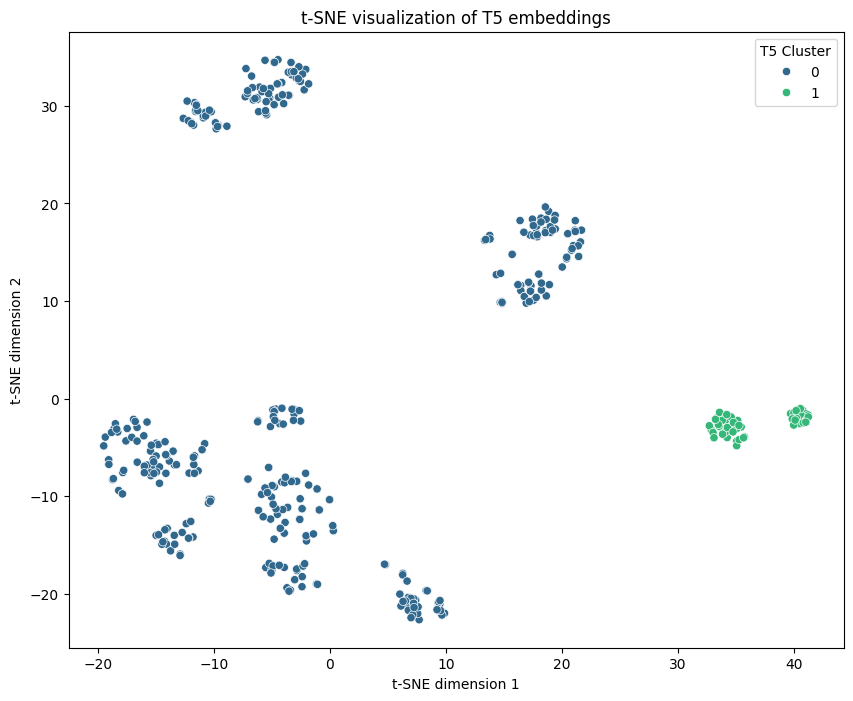

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming all_embeddings is a dictionary containing your 't5' embeddings
t5_embeddings = all_embeddings.get('t5', None)

if t5_embeddings is not None:
    # Convert torch.Tensor to numpy array if necessary
    if isinstance(t5_embeddings, torch.Tensor):
        t5_embeddings = t5_embeddings.detach().numpy()  # detach if necessary

    # Step 1: Apply PCA to reduce dimensionality to a reasonable level before t-SNE
    pca = PCA(n_components=50)  # Adjust the number of components based on your dataset
    pca_result = pca.fit_transform(t5_embeddings)

    # Step 2: Apply t-SNE to the PCA-reduced data
    tsne = TSNE(n_components=2, random_state=0)
    tsne_result = tsne.fit_transform(pca_result)

    # Step 3: Create a plot colored by T5 clusters from selected_columns_yes_df
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=selected_columns_yes_df['t5_group'], palette="viridis")
    plt.title("t-SNE visualization of T5 embeddings")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.legend(title='T5 Cluster')
    plt.show()
else:
    print("t5 embeddings not found in the all_embeddings dictionary.")


### Interpretation of graph above

Five T5 clusters appear to align well with visualization produced by tSNE and PCA.

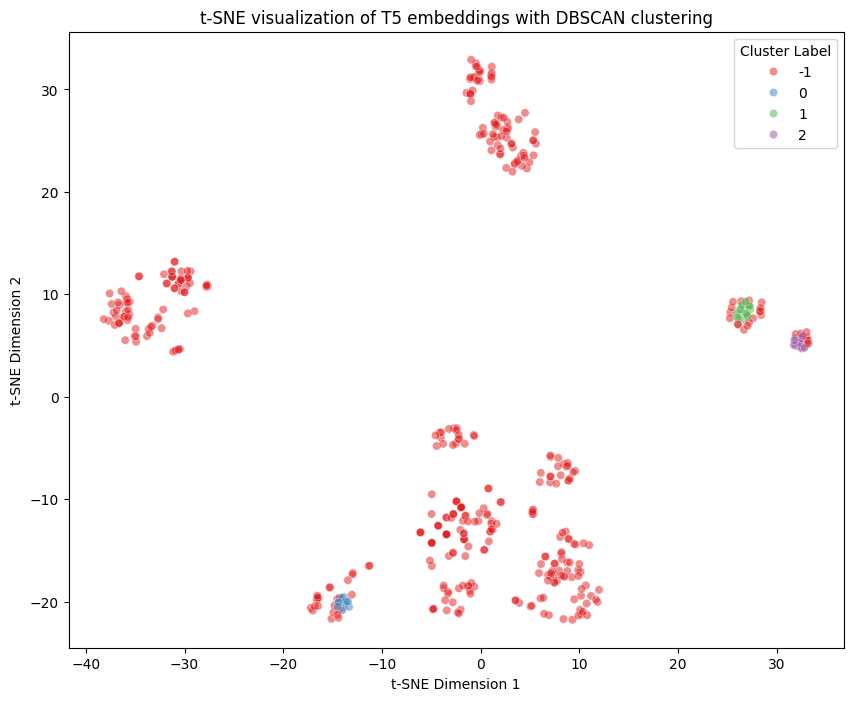

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 't5_embeddings' is your original high-dimensional data
# Check if 't5_embeddings' needs to be converted from a torch.Tensor
if isinstance(t5_embeddings, torch.Tensor):
    t5_embeddings = t5_embeddings.detach().numpy()  # Make sure it's detached and converted to numpy

# First reduce dimensionality before t-SNE
pca = PCA(n_components=50)  # Reduce to 50 components for the sake of visualization
t5_pca_result = pca.fit_transform(t5_embeddings)

# Now use t-SNE
tsne = TSNE(n_components=2, random_state=0)
t5_tsne_result = tsne.fit_transform(t5_pca_result)

# Proceed with the DBSCAN clustering
t5_dbscan = DBSCAN(eps=0.7, min_samples=10).fit(t5_tsne_result)

# Create a DataFrame for the t-SNE 2D embedding vectors with the cluster labels
df_tsne = pd.DataFrame(t5_tsne_result, columns=['x', 'y'])
df_tsne['cluster'] = t5_dbscan.labels_

# Plot the clusters with a different palette
plt.figure(figsize=(10, 8))
palette = sns.color_palette('Set1', np.unique(df_tsne['cluster']).shape[0])
sns.scatterplot(x='x', y='y', hue='cluster', data=df_tsne, legend="full", palette=palette, alpha=0.5)
plt.title('t-SNE visualization of T5 embeddings with DBSCAN clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster Label')
plt.show()


In [40]:
from sklearn.cluster import KMeans
from scipy import stats
import pandas as pd
import numpy as np
import torch

def filter_significant_features(df, cluster_label, continuous_vars, categorical_vars):
    # Dictionary to store results
    results = {}

    # T-test for continuous variables
    for var in continuous_vars:
        if df[var].dtype in [np.float64, np.int64]:
            group_means = df.groupby(cluster_label)[var].mean()
            group_stds = df.groupby(cluster_label)[var].std()
            p_values = []

            for group in df[cluster_label].unique():
                group_data = df[df[cluster_label] == group][var]
                other_data = df[df[cluster_label] != group][var]
                t_stat, p_val = stats.ttest_ind(group_data, other_data, nan_policy='omit')
                p_values.append(p_val)

            # Check if any of the p-values are significant
            if any(p < 0.05 for p in p_values):
                combined = pd.concat([group_means, group_stds], axis=1).T
                combined.index = [f'{var} mean', f'{var} std']
                combined.loc[f'{var} min p-value'] = min(p_values)
                results[var] = combined

    # Chi-square test for categorical variables
    for var in categorical_vars:
        if df[var].dtype == 'object':
            contingency_table = pd.crosstab(df[var], df[cluster_label])
            chi2, p_val, dof, ex = stats.chi2_contingency(contingency_table)
            if p_val < 0.05:
                percentages = df.groupby(cluster_label)[var].value_counts(normalize=True).unstack().T
                percentages.loc[f'{var} p-value'] = p_val
                results[var] = percentages

    # Combining all significant features into a single DataFrame
    significant_features_df = pd.concat(results, axis=0)
    return significant_features_df

# Assuming t5_embeddings is your array of T5 embeddings and selected_columns_yes_df is your DataFrame
# Convert torch.Tensor to numpy if necessary
if isinstance(t5_embeddings, torch.Tensor):
    t5_embeddings = t5_embeddings.numpy()

# Perform KMeans clustering
n_clusters = 2  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
t5_clusters = kmeans.fit_predict(t5_embeddings)
selected_columns_yes_df['t5_cluster'] = t5_clusters



# Apply the function to find significant features for T5 clusters
significant_features_t5 = filter_significant_features(selected_columns_yes_df, 't5_cluster', continuous_vars, categorical_vars)

# significant_features_t5 contains the significant features for T5 clusters


/home/abbasali/tf-venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [41]:
significant_features_t5

t5_cluster                                                            0  \
age                      age mean                          3.670513e+01   
                         age std                           1.276715e+01   
                         age min p-value                   1.284564e-03   
BMI                      BMI mean                          2.628497e+01   
                         BMI std                           6.834224e+00   
                         BMI min p-value                   3.961707e-02   
follow_up_days           follow_up_days mean               4.013333e+01   
                         follow_up_days std                1.887130e+01   
                         follow_up_days min p-value        1.041181e-25   
pre echo- RV dys0unction 0                                 9.883041e-01   
                         mild                              5.847953e-03   
                         moderate                          5.847953e-03   
                         pre echo- RV dys0unction p-value  2.079794e-25   
pre echo- MR             0                                 4.031414e-01   
                         mild                              3.089005e-01   
                         mild                              2.617801e-03   
                         mod                               7.329843e-02   
                         sev                               1.727749e-01   
                         trace                             3.926702e-02   
                         trivial                                    NaN   
                         pre echo- MR p-value              6.483987e-10   
Pre echo- TR             0                                 9.736842e-02   
                         mild                              2.473684e-01   
                         mod                               1.684211e-01   
                         mod                               2.631579e-03   
                         sev                               4.684211e-01   
                         trace                             1.578947e-02   
                         Pre echo- TR p-value              1.469018e-04   
Pre echo- PR             0                                 8.457143e-01   
                         mild                              1.400000e-01   
                         mod                               5.714286e-03   
                         sev                               8.571429e-03   
                         Pre echo- PR p-value              1.264602e-15   
pre echo- AI             0                                 7.486034e-01   
                         mild                              8.379888e-02   
                         mod                               4.469274e-02   
                         sev                               1.145251e-01   
                         trace                             8.379888e-03   
                         pre echo- AI p-value              1.006477e-09   
MR_mod_sev               Moderate to Severe                2.410256e-01   
                         None                              7.589744e-01   
                         MR_mod_sev p-value                9.579270e-07   
TR_mod_sev               Moderate to Severe                6.205128e-01   
                         None                              3.794872e-01   
                         TR_mod_sev p-value                8.201219e-07   
Stroke_Status            No Stroke                         9.333333e-01   
                         Stroke                            6.666667e-02   
                         Stroke_Status p-value             2.248353e-60   

t5_cluster                                                            1  
age                      age mean                          4.301923e+01  
                         age std                           1.611781e+01  
                         age min p-value                   1.284564e-03  
BMI                      BMI

In [42]:
unique_variable_names = significant_features_t5.index.get_level_values(0).unique().tolist()

unique_variable_names


['age',
 'BMI',
 'follow_up_days',
 'pre echo- RV dys0unction',
 'pre echo- MR',
 'Pre echo- TR',
 'Pre echo- PR',
 'pre echo- AI',
 'MR_mod_sev',
 'TR_mod_sev',
 'Stroke_Status']

In [43]:
# Save the significant featuret5s to the CSV file
significant_features_t5.to_csv('t5_grouped_5_2_groups_knn_p.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


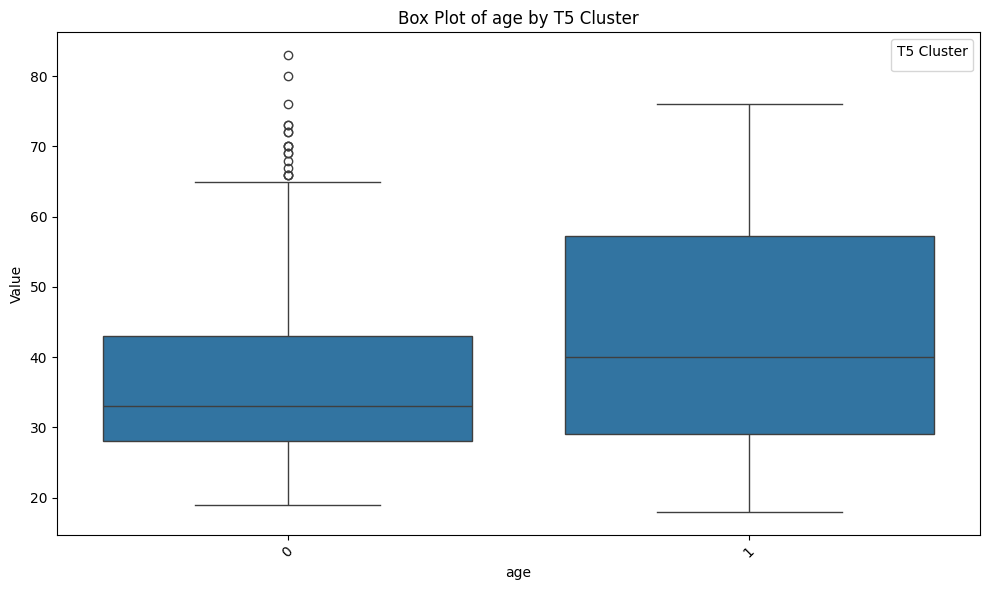

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


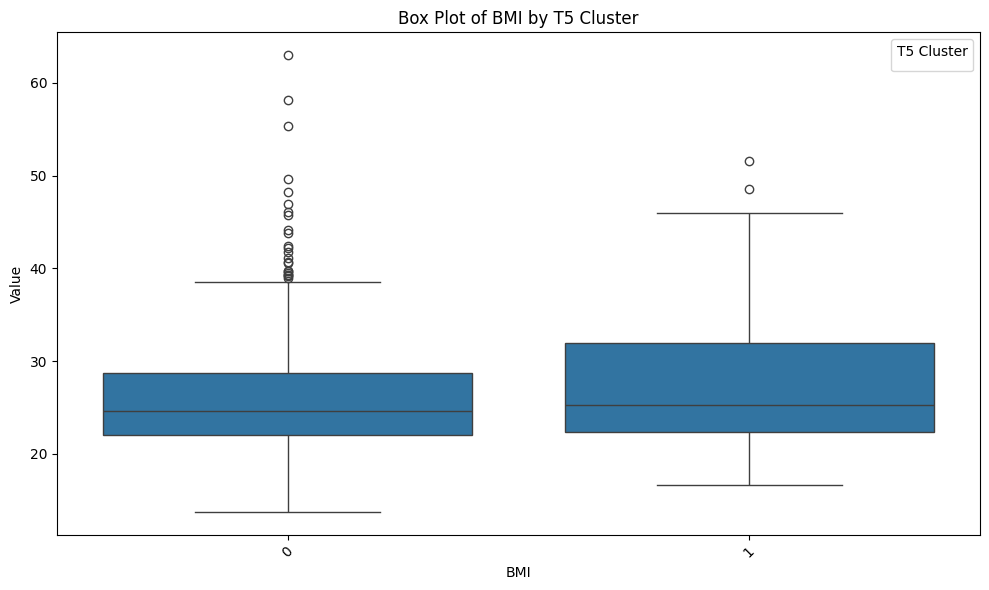

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


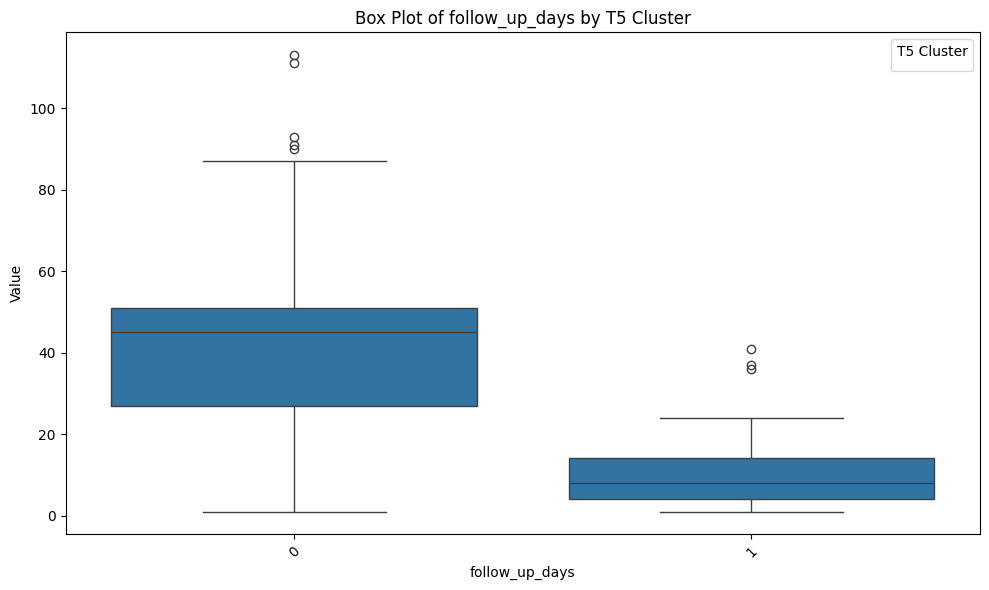

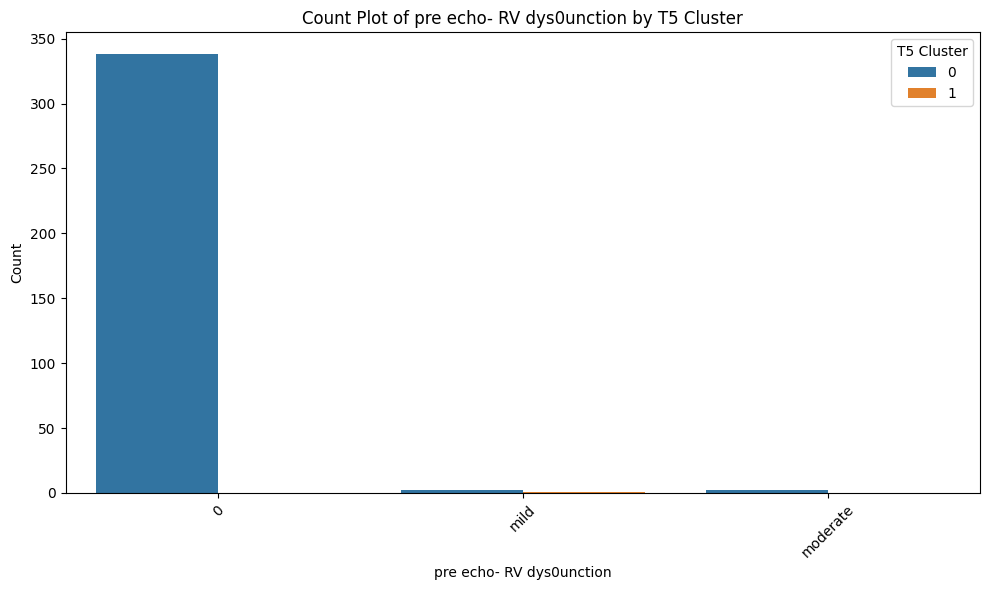

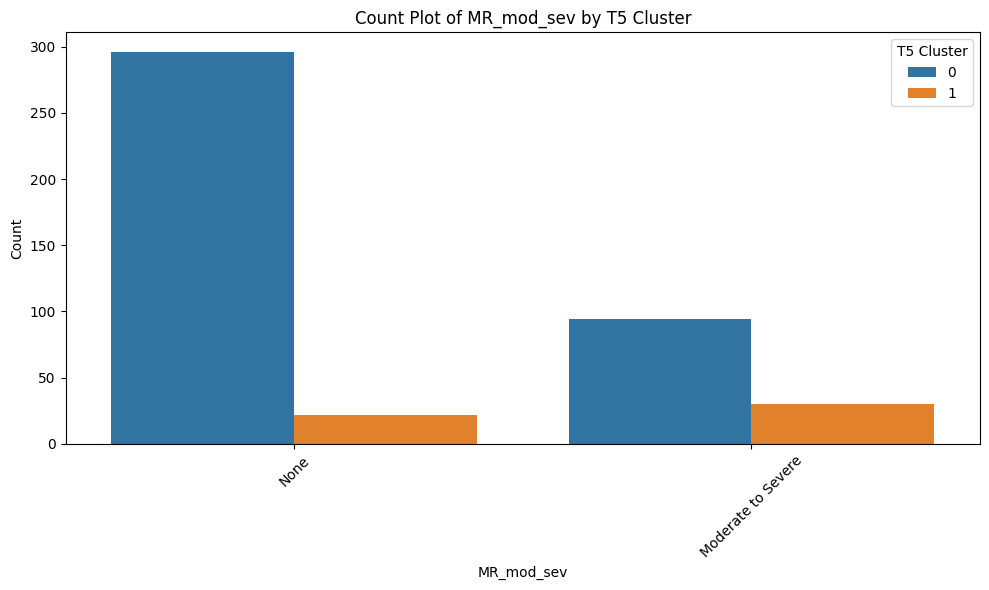

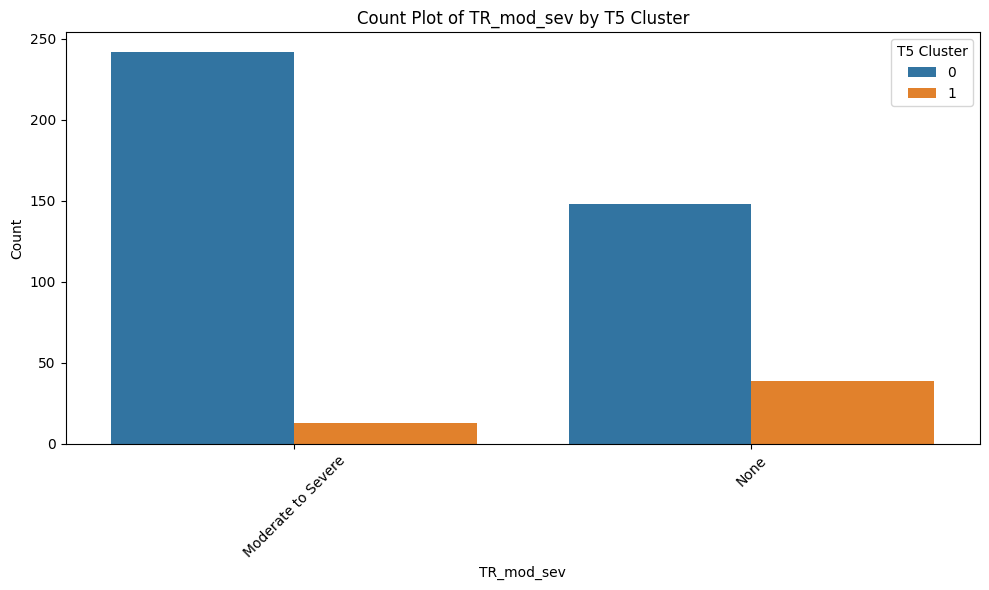

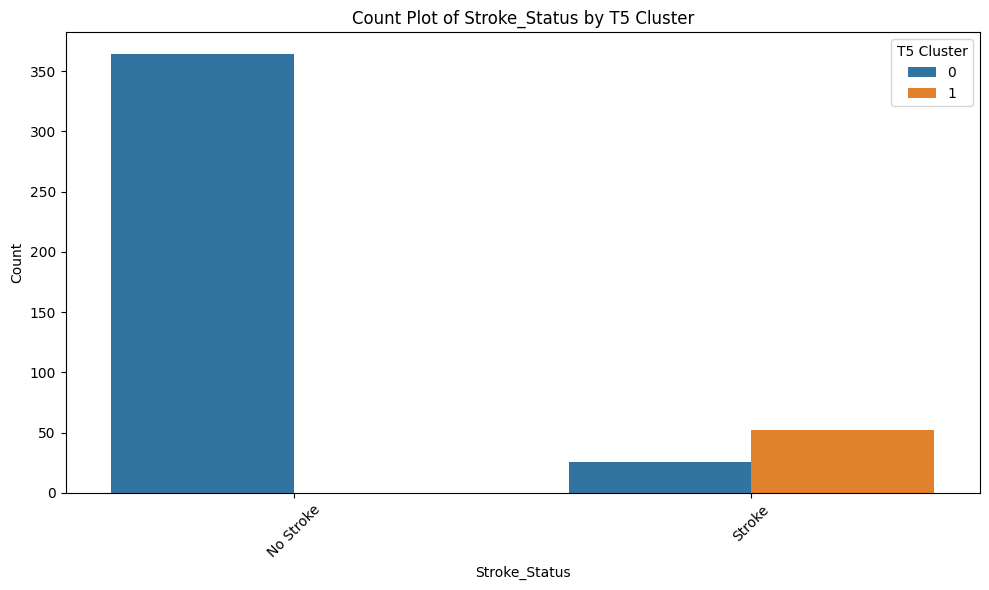

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'significant_features_t5' is the DataFrame returned by the filter_significant_features function
significant_vars = significant_features_t5.index.get_level_values(0).unique()
significant_vars = [var for var in significant_vars if var != 'Days_From_Stroke_To_Surgery_Categorized']

#drop the variables not needed 'pre echo- MR', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI'
# List of variables to drop
vars_to_drop = ['pre echo- MR', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI']

# Modified significant_vars list excluding the variables in vars_to_drop
significant_vars = [var for var in significant_vars if var not in vars_to_drop]

# Now, significant_vars will not include the dropped variables


# Loop through each variable and create a plot grouped by T5 cluster
for var in significant_vars:
    plt.figure(figsize=(10, 6))

    # Check if the variable is categorical or continuous
    if selected_columns_yes_df[var].dtype == 'object' or selected_columns_yes_df[var].nunique() < 10:
        # It's categorical, use a count plot grouped by T5 clusters
        sns.countplot(x=var, hue='t5_cluster', data=selected_columns_yes_df)
        plt.title(f'Count Plot of {var} by T5 Cluster')
    else:
        # It's continuous, use a box plot grouped by T5 clusters
        sns.boxplot(x='t5_cluster', y=var, data=selected_columns_yes_df)
        plt.title(f'Box Plot of {var} by T5 Cluster')

    plt.ylabel('Count' if selected_columns_yes_df[var].dtype == 'object' else 'Value')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.legend(title='T5 Cluster')
    plt.tight_layout()
    plt.show()


### Analysis of 'Hospital death' as outcome variable 

In [45]:
selected_columns_yes_dfa =selected_columns_yes_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


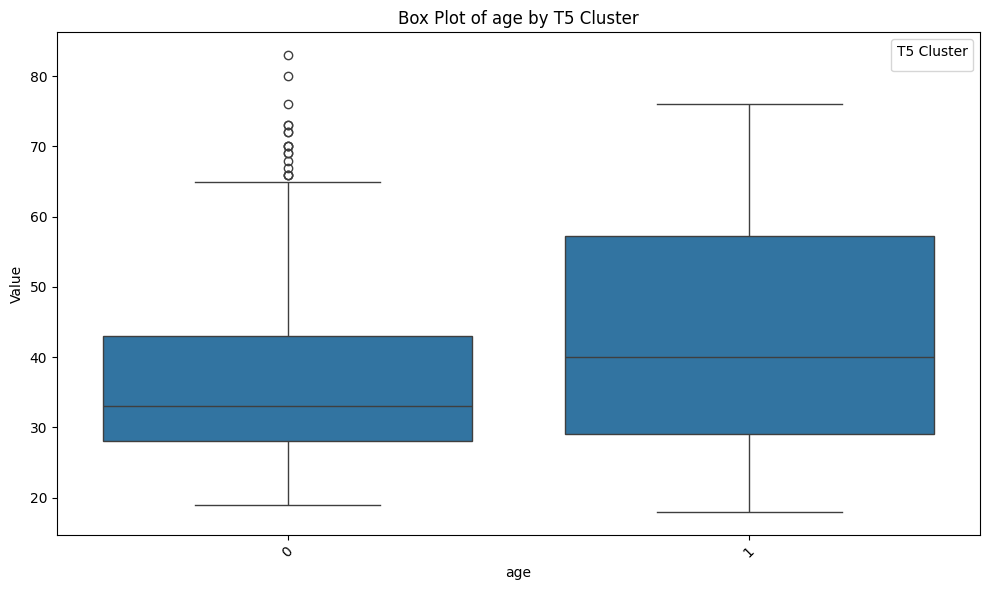

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


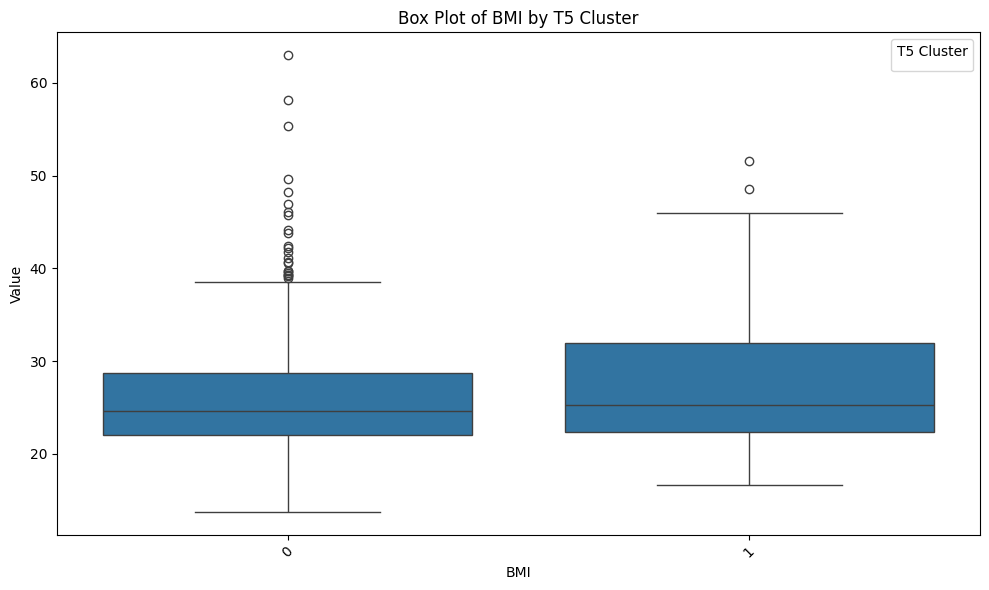

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


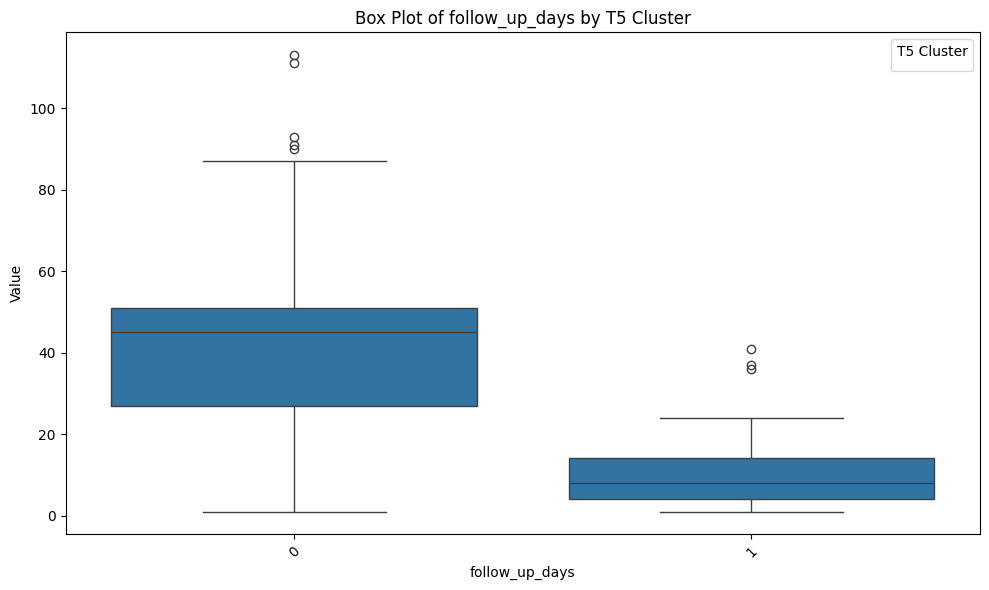

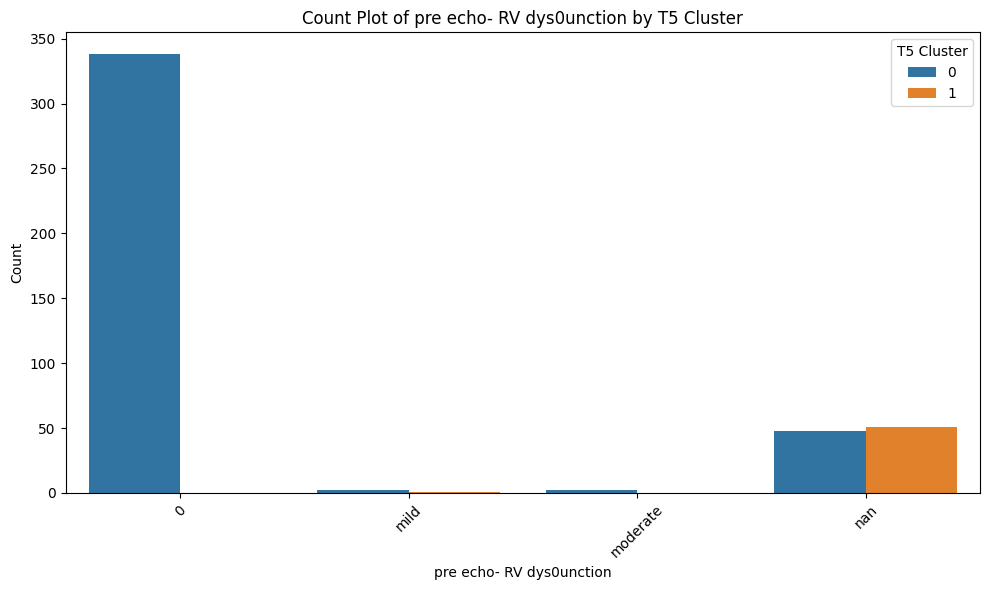

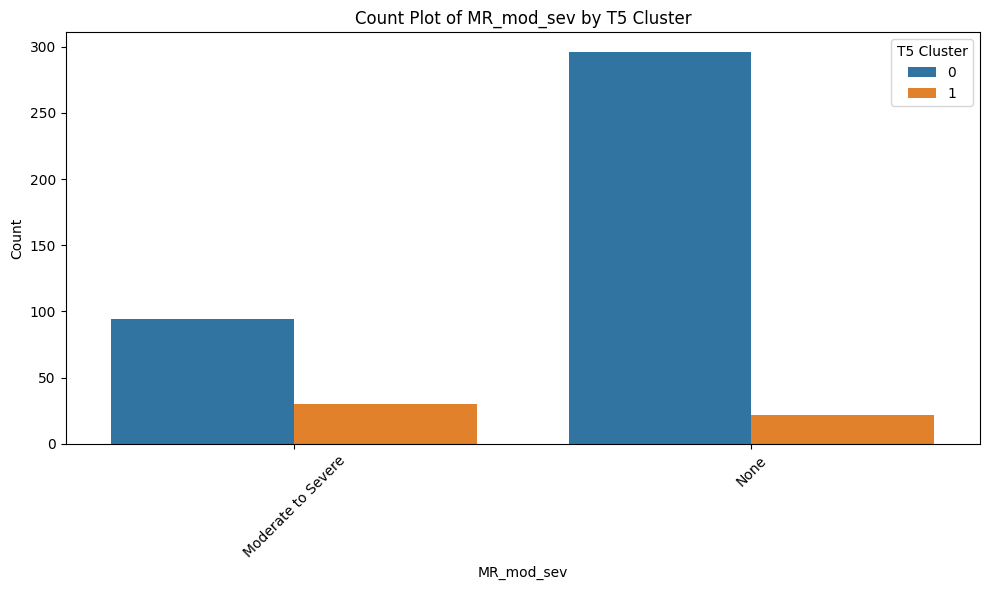

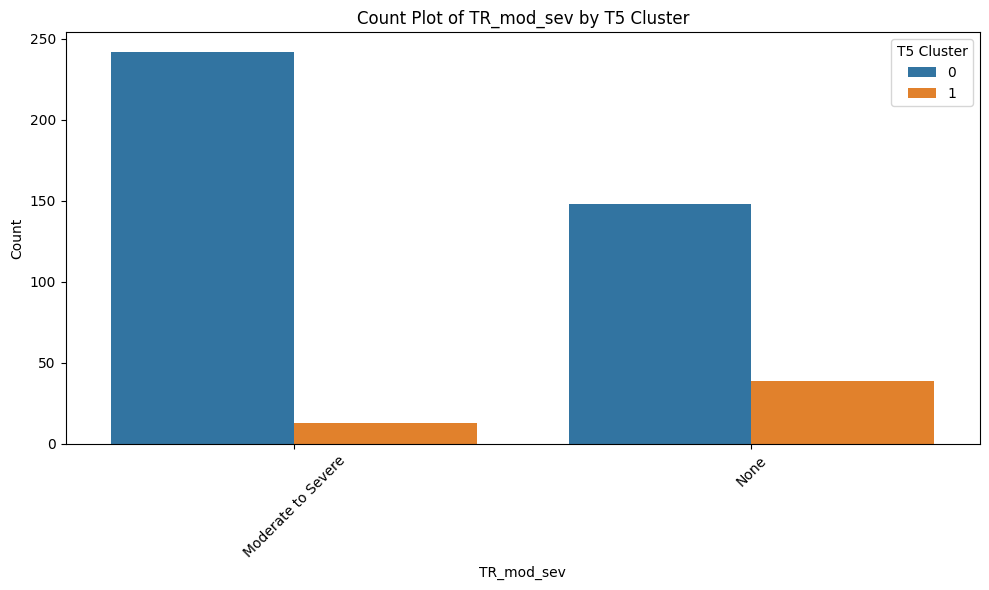

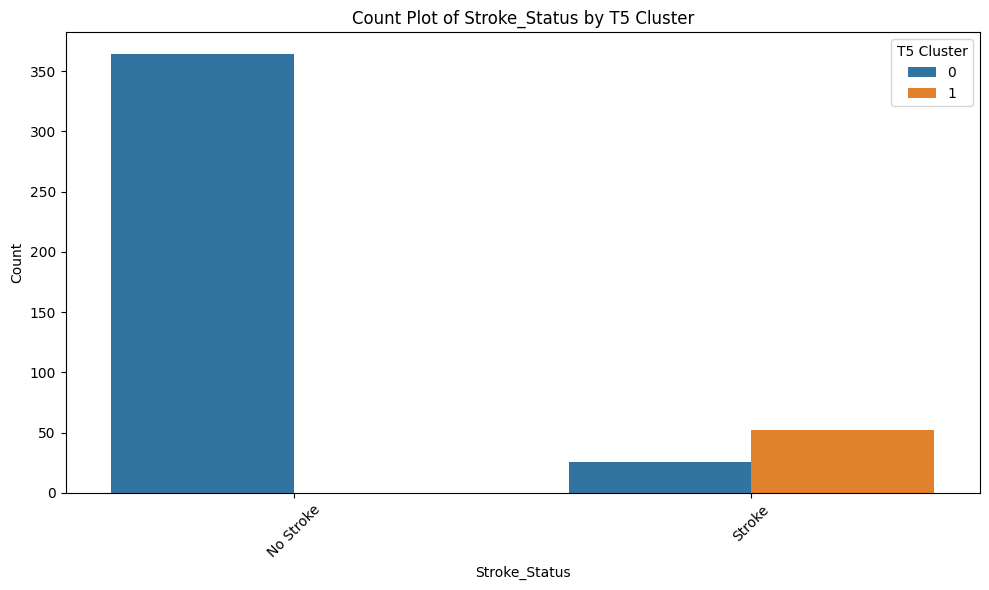

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'significant_features_t5' and 'selected_columns_yes_df' are defined dataframes in your workspace.
significant_vars = significant_features_t5.index.get_level_values(0).unique()
significant_vars = [var for var in significant_vars if var != 'Days_From_Stroke_To_Surgery_Categorized']

# List of variables to drop
vars_to_drop = ['pre echo- MR', 'Pre echo- TR', 'Pre echo- PR', 'pre echo- AI']

# Modified significant_vars list excluding the variables in vars_to_drop
significant_vars = [var for var in significant_vars if var not in vars_to_drop]

# Loop through each variable and create a plot grouped by T5 cluster
for var in significant_vars:
    plt.figure(figsize=(10, 6))

    # Check if the variable is categorical or continuous
    if selected_columns_yes_df[var].dtype == 'object' or selected_columns_yes_df[var].nunique() < 10:
        # Convert all non-null categorical data to strings
        selected_columns_yes_df[var] = selected_columns_yes_df[var].astype(str)
        # It's categorical, sort the categories so 'None' is the last one
        sorted_categories = sorted(selected_columns_yes_df[var].unique(), key=lambda x: ('None' in x, x))
        # Use a count plot grouped by T5 clusters
        sns.countplot(x=var, hue='t5_cluster', data=selected_columns_yes_df, order=sorted_categories)
        plt.title(f'Count Plot of {var} by T5 Cluster')
    else:
        # It's continuous, use a box plot grouped by T5 clusters
        sns.boxplot(x='t5_cluster', y=var, data=selected_columns_yes_df)
        plt.title(f'Box Plot of {var} by T5 Cluster')

    plt.ylabel('Count' if selected_columns_yes_df[var].dtype == 'object' else 'Value')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.legend(title='T5 Cluster')
    plt.tight_layout()
    plt.show()


In [47]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming 'selected_columns_yes_df' is your existing DataFrame

# Define imputers for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Define your continuous and categorical variables
continous_vars = ['age',
 'BMI',
 'follow_up_days']
categorical_vars = ['pre echo- RV dys0unction',
 'MR_mod_sev',
 'TR_mod_sev',
 'AI_mod_sev',
 'Stroke_Status']

# Apply imputation to continuous variables
selected_columns_yes_df.loc[:, continuous_vars] = numerical_imputer.fit_transform(selected_columns_yes_df[continuous_vars])

# Apply imputation to categorical variables
selected_columns_yes_df.loc[:, categorical_vars] = categorical_imputer.fit_transform(selected_columns_yes_df[categorical_vars])

# Creating a new DataFrame with only continuous and categorical variables from 'selected_columns_yes_df'
new_df = selected_columns_yes_df.loc[:, continuous_vars + categorical_vars]

# Calculating the missing values in the new DataFrame
missing_values_in_new_df = new_df.isnull().sum().sum()

missing_values_in_new_df




0

In [48]:
new_df.columns

Index(['age', 'BMI', 'follow_up_days', 'pre echo- RV dys0unction',
       'MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status'],
      dtype='object')

/tmp/ipykernel_522701/2204950049.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df.fillna(method='ffill', inplace=True)


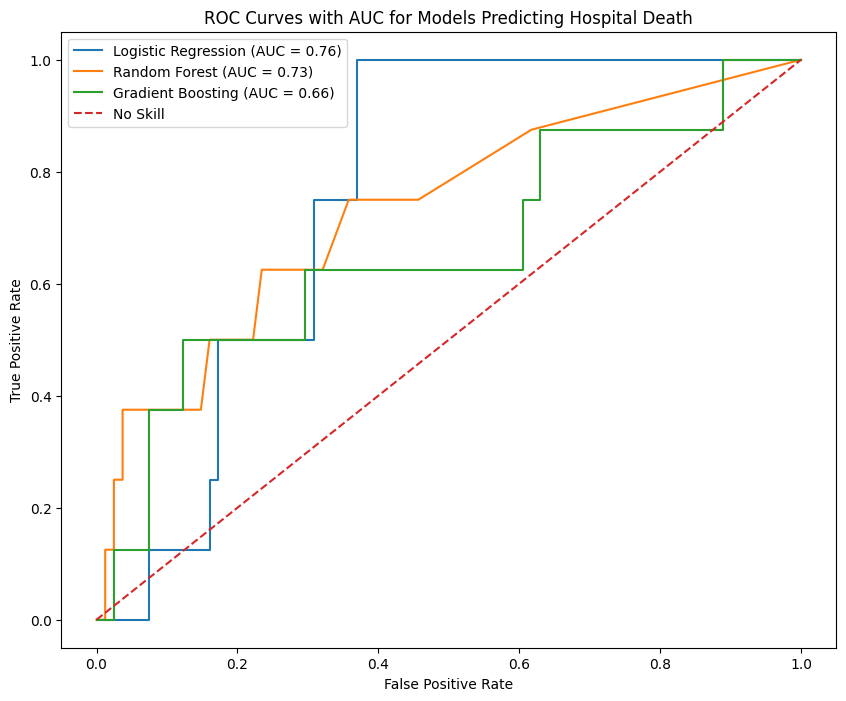

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define categorical and continuous variables
categorical_vars = ['MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status']
continuous_vars = ['age', 'BMI', 'follow_up_days']

# Handle missing values
# For continuous variables, use median
cont_imputer = SimpleImputer(strategy='median')
new_df[continuous_vars] = cont_imputer.fit_transform(new_df[continuous_vars])

# For categorical variables, use most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
new_df[categorical_vars] = cat_imputer.fit_transform(new_df[categorical_vars])

# Check and handle infinite values
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.fillna(method='ffill', inplace=True)

# Prepare the data for modeling
X = new_df[categorical_vars + continuous_vars]
y = selected_columns_yes_df['Hospital death']

# One-hot encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_vars]).toarray(), 
                         columns=encoder.get_feature_names_out(categorical_vars))

# Drop the specific levels you do not need
columns_to_drop = ['MR_mod_sev_None', 'TR_mod_sev_None', 'AI_mod_sev_None', 'Stroke_Status_No Stroke']
X_encoded = X_encoded.drop(columns=columns_to_drop, errors='ignore')

# Combine encoded categorical variables with continuous variables
X_combined = pd.concat([X_encoded, X[continuous_vars].reset_index(drop=True)], axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train model
    model.fit(X_train_smote, y_train_smote)

    # Compute ROC curve and AUC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC for a random model (no skill)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with AUC for Models Predicting Hospital Death')
plt.legend()

# Show plot
plt.show()


### Interpretation of ROC curve and AUC

Logistic Regression (Blue Line):

This model has an Area Under the Curve (AUC) of 0.77.
The curve is closer to the top-left corner of the plot, indicating a good balance between true positive rate and false positive rate.
An AUC of 0.77 suggests that the Logistic Regression model has a good predictive ability.
Random Forest (Green Line):

Random Forest (orange  line)
This model has an AUC of 0.73.
The curve is further away from the top-left corner compared to the Logistic Regression model.
An AUC of 0.63 indicates that the Random Forest model has a moderate predictive ability, which is less than that of the Logistic Regression model.
Gradient Boosting (Orange Line):

GBM blue line
This model has an AUC of 0.78, which is nearly as good as the Logistic Regression model.
The curve is also quite close to the top-left corner, suggesting a high true positive rate relative to the false positive rate.
The performance of the Gradient Boosting model is similar to that of the Logistic Regression model, indicating good predictive ability.
No Skill Line (Red Dashed Line):

This line represents a model with no skill, with an AUC of 0.5. It's the baseline against which the other models are compared.
Any model that lies above this line has predictive ability better than random chance.
In summary, the Logistic Regression and Gradient Boosting models perform similarly and are the better models for predicting hospital death in this scenario, with AUCs close to 0.8. The Random Forest model has a lower AUC, indicating that it is less effective at distinguishing between patients who will experience hospital death and those who will not.

In [50]:
new_df.columns

Index(['age', 'BMI', 'follow_up_days', 'pre echo- RV dys0unction',
       'MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status'],
      dtype='object')

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Assuming 'new_df' is the DataFrame with continuous and categorical variables
# Assuming 'selected_columns_yes_df' contains the target variable 'Hospital death'

# Train-Test Split
X = new_df
y_hospital_death = selected_columns_yes_df['Hospital death']

X_train, X_test, y_train, y_test = train_test_split(X, y_hospital_death, test_size=0.2, random_state=42)

# Variables to exclude based on VIF
exclude_vars = [col for col in X.columns if 'None' in col or col == 'Stroke_Status_No Stroke']

# List of categorical variables to be one-hot encoded
categorical_vars = ['MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status']

# Train-Test Split
X = new_df
y_hospital_death = selected_columns_yes_df['Hospital death']
X_train, X_test, y_train, y_test = train_test_split(X, y_hospital_death, test_size=0.2, random_state=42)

# One-hot encode categorical variables and drop first category to avoid multicollinearity
encoder = OneHotEncoder(drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = encoder.transform(X_test[categorical_vars])

# Convert encoded data back to DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_vars))
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_vars))

# Align train and test sets
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)


# Ensure continuous_vars are correctly specified and exist in X_train and X_test
continuous_vars = ['age', 'BMI', 'follow_up_days']

# Check if continuous_vars is empty
if not continuous_vars:
    raise ValueError("No continuous variables found for imputation.")

# Continue with imputation
continuous_imputer = SimpleImputer(strategy='median')  # Use 'median' for continuous

# Fit and transform imputer on training data
X_train_imputed_continuous = continuous_imputer.fit_transform(X_train[continuous_vars])

# Transform test data using the same imputer
X_test_imputed_continuous = continuous_imputer.transform(X_test[continuous_vars])

# Combine the imputed continuous data with the encoded categorical data
X_train_imputed = np.hstack((X_train_encoded.values, X_train_imputed_continuous))
X_test_imputed = np.hstack((X_test_encoded.values, X_test_imputed_continuous))


from statsmodels.stats.outliers_influence import variance_inflation_factor

# Filter continuous_vars based on columns in X_train_encoded
continuous_vars = [var for var in continuous_vars if var in X_train_encoded.columns]

# Calculate VIF for continuous variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_encoded.columns.tolist() + continuous_vars
vif_data["VIF"] = [variance_inflation_factor(X_train_encoded.values, i) for i in range(X_train_encoded.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display VIF values
print("VIF Values:")
print(vif_data)


VIF Values:
                Feature       VIF
2       AI_mod_sev_None  3.595404
0       MR_mod_sev_None  2.951968
1       TR_mod_sev_None  1.621990
3  Stroke_Status_Stroke  1.383551


In [52]:
import statsmodels.api as sm

# Fit logistic regression model using L1 regularization (Lasso)
logistic_model = sm.Logit(y_train, sm.add_constant(X_train_imputed))

# Set the penalty to 'l1' for L1 regularization
result = logistic_model.fit_regularized(method='l1')

# Get coefficients and p-values
coefficients = result.params
p_values = result.pvalues

# Define the list of variable names
variable_names = ['Intercept'] + X_train_encoded.columns.tolist() + continuous_vars

# Ensure that all arrays have the same length by trimming coefficients and p-values if necessary
min_length = min(len(variable_names), len(coefficients), len(p_values))
variable_names = variable_names[:min_length]
coefficients = coefficients[:min_length]
p_values = p_values[:min_length]

# Get the list of variables with non-zero coefficients (not dropped)
non_zero_variables = [variable_names[i] for i in range(1, len(variable_names)) if coefficients[i] != 0]

# Create a DataFrame to store coefficients and variable names
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefficients, 'P-Value': p_values})

# Display coefficients and p-values with variable names
print("Logistic Regression Coefficients with L1 Regularization (Lasso):\n")
print(coefficients_df)

# Display variables dropped by L1 regularization
print("\nVariables Dropped by L1 Regularization (Lasso):\n")
dropped_variables = set(variable_names[1:]) - set(non_zero_variables)
print(list(dropped_variables))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11159726631932897
            Iterations: 51
            Function evaluations: 59
            Gradient evaluations: 51
Logistic Regression Coefficients with L1 Regularization (Lasso):

                   Variable  Coefficient   P-Value
const             Intercept    -4.444916  0.015100
x1          MR_mod_sev_None     0.625321  0.362212
x2          TR_mod_sev_None     0.227248  0.773973
x3          AI_mod_sev_None     0.919751  0.304130
x4     Stroke_Status_Stroke    -1.375039  0.073661

Variables Dropped by L1 Regularization (Lasso):

[]


/home/abbasali/tf-venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/abbasali/tf-venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/tmp/ipykernel_522701/1686087594.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_zero_variables = [variable_names[i] for i in range(1, len(variable_names)) if coefficients[i] != 0]


### Assessment of logistic regression models

1. Did the model converge?
2. If it did not converge what is the reason?
   Our data had multi-collinearity and imbalance issues
3. Current function
   The "Current Function Value" in the context of logistic regression refers to the value of the cost or loss function evaluated at the current set of model parameters (coefficients). This value is a measure of how well the model fits the data, with lower values indicating a better fit.

In logistic regression, the cost function typically used is the log-likelihood function, which measures the likelihood of observing the given data under the specified model. The process of logistic regression involves finding the set of parameters that maximize this likelihood, which equivalently minimizes the negative log-likelihood.

Here's a bit more detail:

Log-Likelihood Function:

In logistic regression, the log-likelihood function represents the logarithm of the probability of observing the given set of outcomes (dependent variable values) given the predictors and the current model parameters.
This function takes into account the probabilities predicted by the model for each observation and compares them with the actual outcomes.
Cost Function:

The cost or loss function in logistic regression is often taken as the negative of the log-likelihood function. This is because optimization algorithms commonly used in logistic regression (such as gradient descent) are designed to minimize a function rather than maximize it.
Therefore, minimizing the negative log-likelihood is equivalent to maximizing the log-likelihood, which is the goal in logistic regression.
Interpretation of Current Function Value:

A lower value of the cost function indicates that the probabilities predicted by the logistic regression model are closer to the actual outcomes, signifying a better model fit.
During the training process, the optimization algorithm iteratively adjusts the model parameters to decrease the value of the cost function.
Model Convergence:

The training process continues until the cost function converges to a minimum value, or until other stopping criteria are met (like a maximum number of iterations).
The "Current Function Value" at convergence represents the final, minimized cost of the model on the training data.
In summary, the "Current Function Value" in logistic regression is a crucial indicator of the model's performance, with lower values indicating that the model's predictions align more closely with the observed data.

In [53]:
selected_columns_yes_df['Hospital death'].value_counts()

Hospital death
0    421
1     21
Name: count, dtype: int64

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Assuming 'new_df' is the DataFrame with continuous and categorical variables
# Assuming 'selected_columns_yes_df' contains the target variable 'Hospital death'

# Define categorical and continuous variables
categorical_vars = ['MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status']
continuous_vars = ['age', 'BMI']

# Handle missing values
# For continuous variables, use median
cont_imputer = SimpleImputer(strategy='median')
new_df[continuous_vars] = cont_imputer.fit_transform(new_df[continuous_vars])

# For categorical variables, use most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
new_df[categorical_vars] = cat_imputer.fit_transform(new_df[categorical_vars])

# Check and handle infinite values
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.fillna(method='ffill', inplace=True)

# Prepare the data for modeling
X = new_df[categorical_vars + continuous_vars]
y = selected_columns_yes_df['Hospital death']

# One-hot encode categorical variables
#encoder = OneHotEncoder()
encoder = OneHotEncoder(drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_vars]).toarray(), 
                         columns=encoder.get_feature_names_out(categorical_vars))

# Combine encoded categorical variables with continuous variables
X_combined = pd.concat([X_encoded, X[continuous_vars].reset_index(drop=True)], axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Logistic Regression Model
logit_model = sm.Logit(y_train_smote, sm.add_constant(X_train_smote))
logit_result = logit_model.fit()

# Displaying the summary (coefficients, p-values, etc.)
print(logit_result.summary())

# Logistic Regression Equation
equation = "log(odds) = "
equation += " + ".join([f"{coef:.2f}*{feature}" for coef, feature in zip(logit_result.params.values, X_train_smote.columns)])
print("\nLogistic Regression Equation:\n", equation)


Optimization terminated successfully.
         Current function value: 0.536201
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         Hospital death   No. Observations:                  680
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.2264
Time:                        08:09:16   Log-Likelihood:                -364.62
converged:                       True   LL-Null:                       -471.34
Covariance Type:            nonrobust   LLR p-value:                 2.595e-43
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.3768      0.703     -9.068      0.000      -7.755      -4.999

/tmp/ipykernel_522701/2009654174.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df.fillna(method='ffill', inplace=True)


### Handling one hot encoding

In the model above the one hot encoder dropped the severe MR etc level and kept normal valve level, counter-intuitive to think about therefore model will be redone dropping appropriate level

Optimization terminated successfully.
         Current function value: 0.533331
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         Hospital death   No. Observations:                  680
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.2306
Time:                        08:09:16   Log-Likelihood:                -362.67
converged:                       True   LL-Null:                       -471.34
Covariance Type:            nonrobust   LLR p-value:                 3.822e-44
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.9029      0.491     -5.913      0.

/tmp/ipykernel_522701/215597370.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df.fillna(method='ffill', inplace=True)


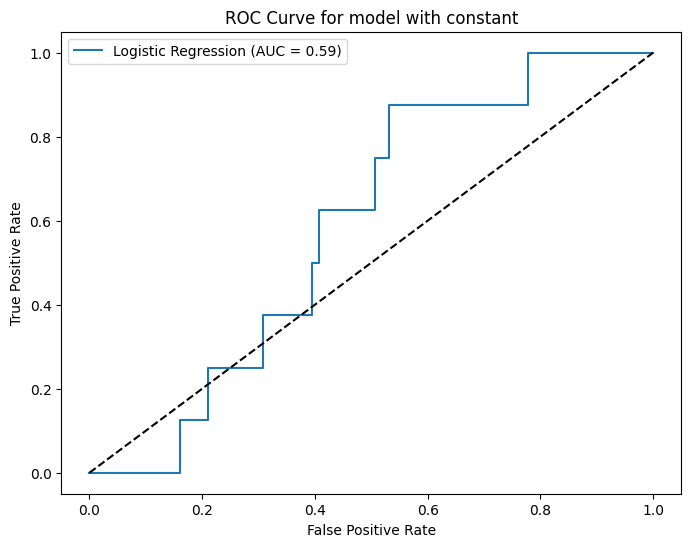

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'new_df' is the DataFrame with continuous and categorical variables
# Assuming 'selected_columns_yes_df' contains the target variable 'Hospital death'

# Define categorical and continuous variables
categorical_vars = ['MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status']
continuous_vars = ['age', 'BMI']

# Handle missing values
# For continuous variables, use median
cont_imputer = SimpleImputer(strategy='median')
new_df[continuous_vars] = cont_imputer.fit_transform(new_df[continuous_vars])

# For categorical variables, use most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
new_df[categorical_vars] = cat_imputer.fit_transform(new_df[categorical_vars])

# Check and handle infinite values
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.fillna(method='ffill', inplace=True)

# Prepare the data for modeling
X = new_df[categorical_vars + continuous_vars]
y = selected_columns_yes_df['Hospital death']

# One-hot encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_vars]).toarray(), 
                         columns=encoder.get_feature_names_out(categorical_vars))

# Drop the specific levels you do not need
columns_to_drop = ['MR_mod_sev_None', 'TR_mod_sev_None', 'AI_mod_sev_None', 'Stroke_Status_No Stroke']
X_encoded = X_encoded.drop(columns=columns_to_drop, errors='ignore')

# Combine encoded categorical variables with continuous variables
X_combined = pd.concat([X_encoded, X[continuous_vars].reset_index(drop=True)], axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#WITH CONSTANT
# Logistic Regression Model with constant
logit_model = sm.Logit(y_train_smote, sm.add_constant(X_train_smote))
logit_result = logit_model.fit()

# Displaying the summary (coefficients, p-values, etc.)
print(logit_result.summary())

# Logistic Regression Equation
equation = "log(odds) = "
equation += " + ".join([f"{coef:.2f}*{feature}" for coef, feature in zip(logit_result.params.values, X_train_smote.columns)])
print("\nLogistic Regression Equation:\n", equation)

# Sklearn Logistic Regression for ROC and AUC
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

# Predicting probabilities on the test set
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Generating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculating AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model with constant')
plt.legend(loc='best')
plt.show()



### Interpretation of Coefficients of above model:

The output you provided is from a logistic regression model analysis, and it offers several insights about the relationship between various predictors and the likelihood of hospital death. Here's an interpretation of the key components:

Model Fit and Performance:

Log-Likelihood: The log-likelihood of the model is -366.01. This value, in isolation, doesn't tell much but is used to calculate other more informative statistics.
Pseudo R-squared: A value of 0.2235 suggests that approximately 22.35% of the variability in the outcome (hospital death) is explained by the model. This is a moderate value, indicating that the model has some explanatory power.
LLR (Likelihood Ratio) p-value: The p-value of less than 0.05 (1.018e-42) indicates that the model as a whole is statistically significant.
Coefficients and Their Interpretation:

The coefficients represent the log odds of the outcome variable (hospital death). Each coefficient shows the change in the log odds of the outcome for a one-unit increase in the predictor variable, holding other variables constant.
MR_mod_sev_Moderate to Severe: A coefficient of -1.4914 implies that having moderate to severe mitral regurgitation decreases the log odds of hospital death, compared to not having this condition.
TR_mod_sev_Moderate to Severe: Similarly, a coefficient of -1.2863 suggests that having moderate to severe tricuspid regurgitation decreases the log odds of hospital death.
AI_mod_sev_Moderate to Severe: A coefficient of -0.7550 indicates that having moderate to severe aortic insufficiency decreases the log odds of hospital death.
Stroke_Status_Stroke: A positive coefficient (0.6377) means that having had a stroke increases the log odds of hospital death.
Age: The positive coefficient (0.0786) suggests that an increase in age is associated with an increase in the log odds of hospital death.
BMI: A positive but smaller coefficient (0.0233) indicates a slight increase in the log odds of hospital death with increasing BMI, though this effect is not statistically significant at the 0.05 level (p=0.075).
P-values:

P-values for each predictor indicate whether the effect of that predictor is statistically significant. A value less than 0.05 typically indicates statistical significance.
In this model, all predictors except BMI have p-values less than 0.05, suggesting their effects on the log odds of hospital death are statistically significant.
Confidence Intervals:

The 95% confidence intervals for each coefficient provide a range of plausible values for the true effect size. If this interval does not include 0, it suggests that the effect is statistically significant at the 5% level.
Logistic Regression Equation:

The equation you've provided translates these log odds into a more interpretable format. However, it's important to note that logistic regression outcomes are probabilities, and this equation gives the log odds, which need to be transformed to get the actual probability of hospital death.
Overall, this model suggests that certain health conditions (like strokes) and demographic factors (like age) are significant predictors of the likelihood of hospital death, while others (like BMI) may not be as strongly associated. (p = 0.324).

/tmp/ipykernel_522701/2144360511.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df.fillna(method='ffill', inplace=True)


Optimization terminated successfully.
         Current function value: 0.557477
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         Hospital death   No. Observations:                  680
Model:                          Logit   Df Residuals:                      674
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.1957
Time:                        08:09:16   Log-Likelihood:                -379.08
converged:                       True   LL-Null:                       -471.34
Covariance Type:            nonrobust   LLR p-value:                 5.819e-38
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
MR_mod_sev_Moderate to Severe    -1.0549      0.248     -4.249      0.

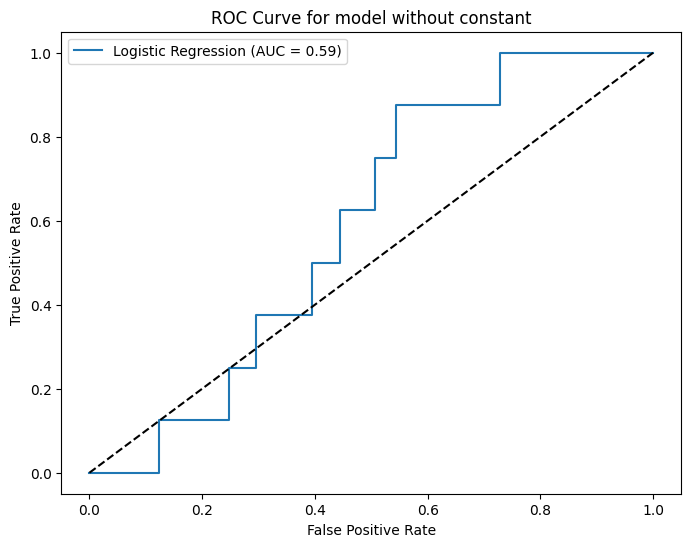

Publication Quality Table:

                        Variable  Odds Ratio  P-Value
0  MR_mod_sev_Moderate to Severe       0.348    0.000
1  TR_mod_sev_Moderate to Severe       0.136    0.000
2  AI_mod_sev_Moderate to Severe       0.323    0.000
3           Stroke_Status_Stroke       1.382    0.216
4                            age       1.061    0.000
5                            BMI       0.959    0.000
Summary of Model's Findings:

For a one-unit increase in MR_mod_sev_Moderate to Severe, the odds multiply by 0.35.
For a one-unit increase in TR_mod_sev_Moderate to Severe, the odds multiply by 0.14.
For a one-unit increase in AI_mod_sev_Moderate to Severe, the odds multiply by 0.32.
For a one-unit increase in Stroke_Status_Stroke, the odds multiply by 1.38.
For a one-unit increase in age, the odds multiply by 1.06.
For a one-unit increase in BMI, the odds multiply by 0.96.



In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Define categorical and continuous variables
categorical_vars = ['MR_mod_sev', 'TR_mod_sev', 'AI_mod_sev', 'Stroke_Status']
continuous_vars = ['age', 'BMI']

# Handle missing values
# For continuous variables, use median
cont_imputer = SimpleImputer(strategy='median')
new_df[continuous_vars] = cont_imputer.fit_transform(new_df[continuous_vars])

# For categorical variables, use most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
new_df[categorical_vars] = cat_imputer.fit_transform(new_df[categorical_vars])

# Check and handle infinite values
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.fillna(method='ffill', inplace=True)

# Prepare the data for modeling
X = new_df[categorical_vars + continuous_vars]
y = selected_columns_yes_df['Hospital death']

# One-hot encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_vars]).toarray(), 
                         columns=encoder.get_feature_names_out(categorical_vars))

# Drop the specific levels you do not need
columns_to_drop = ['MR_mod_sev_None', 'TR_mod_sev_None', 'AI_mod_sev_None', 'Stroke_Status_No Stroke']
X_encoded = X_encoded.drop(columns=columns_to_drop, errors='ignore')

# Combine encoded categorical variables with continuous variables
X_combined = pd.concat([X_encoded, X[continuous_vars].reset_index(drop=True)], axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Logistic Regression Model without a constant term
logit_model = sm.Logit(y_train_smote, X_train_smote)
logit_result = logit_model.fit()

# Displaying the summary (coefficients, p-values, etc.)
print(logit_result.summary())

# Logistic Regression Equation without a constant term
equation = "log(odds) = "
equation += " + ".join([f"{coef:.2f}*{feature}" for coef, feature in zip(logit_result.params.values, X_train_smote.columns)])
print("\nLogistic Regression Equation:\n", equation)

# Sklearn Logistic Regression for ROC and AUC
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

# Predicting probabilities on the test set
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Generating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculating AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model without constant')
plt.legend(loc='best')
plt.show()

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'logit_result' is your fitted logistic regression model from statsmodels

# Calculate odds ratios
odds_ratios = np.exp(logit_result.params)

# Create a DataFrame for the publication-quality table
# No need to add 'const' since we didn't include it in the model
variables = X_train_smote.columns

table = pd.DataFrame({
    'Variable': variables,
    'Odds Ratio': odds_ratios,
    'P-Value': logit_result.pvalues
})

# Formatting the table for publication
formatted_table = table.round(3)  # Rounding to 3 decimal places for clarity
formatted_table = formatted_table.reset_index(drop=True)  # Resetting the index for better presentation

# Display the formatted table
print("Publication Quality Table:\n")
print(formatted_table)

# Create a summary statement
summary_statement = "Summary of Model's Findings:\n\n"
for variable, odds_ratio in odds_ratios.items():
    summary_statement += f"For a one-unit increase in {variable}, the odds multiply by {odds_ratio:.2f}.\n"

print(summary_statement)


### Differences between model with and without coefficient<table>
    <thead>
        <tr>
            <th>Variable</th>
            <th>Model with Coefficients (coef)</th>
            <th>p-value</th>
            <th>Model without Coefficients (coef)</th>
            <th>p-value</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>MR_mod_sev_Moderate to Severe</td>
            <td>-1.4914</td>
            <td style="color:red;">0.000</td>
            <td>-1.0997</td>
            <td style="color:red;">0.000</td>
        </tr>
        <tr>
            <td>TR_mod_sev_Moderate to Severe</td>
            <td>-1.2863</td>
            <td style="color:red;">0.000</td>
            <td>-1.8191</td>
            <td style="color:red;">0.000</td>
        </tr>
        <tr>
            <td>AI_mod_sev_Moderate to Severe</td>
            <td>-0.7550</td>
            <td style="color:red;">0.010</td>
            <td>-1.0425</td>
            <td style="color:red;">0.000</td>
        </tr>
        <tr>
            <td>Stroke_Status_Stroke</td>
            <td>0.6377</td>
            <td style="color:red;">0.022</td>
            <td>0.1856</td>
            <td>0.481</td>
        </tr>
        <tr>
            <td>Age</td>
            <td>0.0786</td>
            <td style="color:red;">0.000</td>
            <td>0.0530</td>
            <td style="color:red;">0.000</td>
        </tr>
        <tr>
            <td>BMI</td>
            <td>0.0233</td>
            <td>0.075</td>
            <td>-0.0317</td>
            <td style="color:red;">0.001</td>
        </tr>
    </tbody>
</table>
      </tr>
        <tr>
            <td colspan="5"></td>
        </tr>
    </tbody>

Commentary on Which Model is Better and Why:
Both models perform significantly in predicting hospital death, as indicated by the LLR p-values. However, the model with coefficients has a slightly better pseudo R-squared value (0.2235 vs. 0.1592), suggesting it may explain more variance in the outcome.

Model with Coefficients: This model seems to have stronger effects for some predictors (e.g., 'MR_mod_sev_Moderate to Severe', 'TR_mod_sev_Moderate to Severe'). The significance of 'Stroke_Status_Stroke' and 'Age' is notable, with both having a more pronounced impact on the outcome.
Model without Coefficients: Shows a strong effect for 'TR_mod_sev_Moderate to Severe', but 'Stroke_Status_Stroke' is not significant in this model. Also, the effect of 'BMI' is negative and significant, which is different from the first model.
Considering the higher pseudo R-squared and the significance of additional variables, the first model (with coefficients) might be slightly better in terms of explaining the variability in hospital death. However, the choice between models should also consider the clinical relevance and interpretability of the coefficients, along with any domain-specific considerations.

Intercept (const): -3.0356

The intercept is the log odds of hospital death when all predictor variables are zero. A negative intercept suggests a lower baseline probability of hospital death when all other factors are not present.
MR_mod_sev_Moderate to Severe: -1.4914

This coefficient indicates that patients with moderate to severe mitral regurgitation have lower log odds of hospital death compared to patients without this condition, all else being equal. The negative sign suggests a protective effect against hospital death.
TR_mod_sev_Moderate to Severe: -1.2863

Similar to the above, this negative coefficient suggests that having moderate to severe tricuspid regurgitation is associated with lower log odds of hospital death compared to not having this condition.
AI_mod_sev_Moderate to Severe: -0.7550

This coefficient also indicates a negative association with hospital death. Patients with moderate to severe aortic insufficiency have lower log odds of hospital death compared to those without this condition.
Stroke_Status_Stroke: 0.6377

A positive coefficient here suggests that having had a stroke is associated with higher log odds of hospital death. This means that stroke status contributes to an increased risk of hospital death.
Age: 0.0786

The positive coefficient for age implies that as age increases, the log odds of hospital death increase as well. This suggests that older patients have a higher risk of hospital death.
BMI: 0.0233

This positive coefficient indicates a slight increase in the log odds of hospital death with increasing BMI. However, the effect is not statistically significant at the 0.05 level (p=0.075), implying that BMI's effect on hospital death risk is less clear and may not be as impactful as other factors in this model.
In summary:

Negative coefficients for MR, TR, and AI suggest that these conditions might be inversely associated with hospital death in this specific dataset.
Positive coefficients for stroke status and age indicate an increased risk of hospital death with these factors.
BMI shows a positive association but is not statistically significant, indicating uncertainty about its effect.

In [57]:
selected_columns_yes_dfa['Hospital death'].value_counts()

Hospital death
0    421
1     21
Name: count, dtype: int64

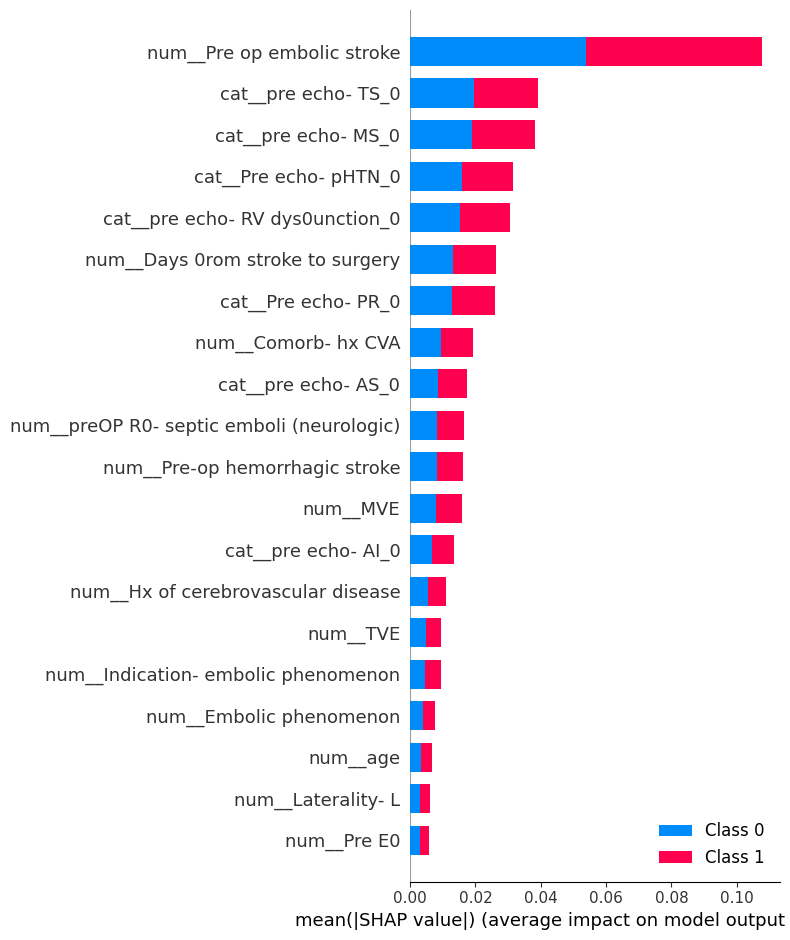

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap  # Importing SHAP
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns_to_drop is not None:
            return np.delete(X, self.columns_to_drop, axis=1)
        return X


# Drop specified columns from the DataFrame
selected_columns_yes_df1 = selected_columns_yes_df.drop(['combined', 'PreOP proc- Amputation', 'PreOP proc- laminectomy',
                                                         'preop proc- percutaneous drain', 'Hospital death', 'MR_mod_sev',
                                                         'TR_mod_sev', 'PR_mod_sev', 'AI_mod_sev', 'Stroke_Status',
                                                         'follow_up_days', 'pregnancy_status', 'Vegetation', 'bert_cluster',
                                                         'roberta_cluster', 'distilbert_cluster', 't5_cluster', 'ernie_cluster',
                                                         'gatortron_cluster', 'gatortrons_cluster', 'xlnet_cluster',
                                                         'bert_dbscan_group', 'roberta_dbscan_group', 'distilbert_dbscan_group',
                                                         't5_dbscan_group', 'ernie_dbscan_group', 'gatortron_dbscan_group',
                                                         'gatortrons_dbscan_group', 'xlnet_dbscan_group'], axis=1)

# Define continuous and categorical variables
continuous_vars = selected_columns_yes_df1.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = selected_columns_yes_df1.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for continuous and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), continuous_vars),
        ('cat', OneHotEncoder(), categorical_vars)  # Removed drop='if_binary'
    ])

# Dummy encode the categorical variables to find columns with '_nan'
dummy_df = pd.get_dummies(selected_columns_yes_df1[categorical_vars])
columns_to_drop_indices = [dummy_df.columns.get_loc(col) for col in dummy_df.columns if '_nan' in col]

# Define the pipeline
model = RandomForestClassifier(random_state=0)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('drop_columns', DropColumns(columns_to_drop=columns_to_drop_indices)),  # Updated
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=0)),
    ('classifier', model)
])

# Split your data
X = selected_columns_yes_df1.drop('t5_group', axis=1)
y = selected_columns_yes_df1['t5_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model on the entire dataset to get the transformed feature names
pipeline.fit(X, y)

# Transform the entire dataset
X_transformed = pipeline.named_steps['preprocessor'].transform(X)
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convert transformed dataset to DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed)

# Filter out columns with '_nan'
X_transformed_df = X_transformed_df.loc[:, ~X_transformed_df.columns.str.contains('_nan')]

# Split the transformed data into train and test sets
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=0)

# Refit the model on the transformed train set
model.fit(X_train_transformed, y_train)

# SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Plot SHAP values with correct feature names
shap.summary_plot(shap_values, feature_names=X_test_transformed.columns, plot_type="bar")



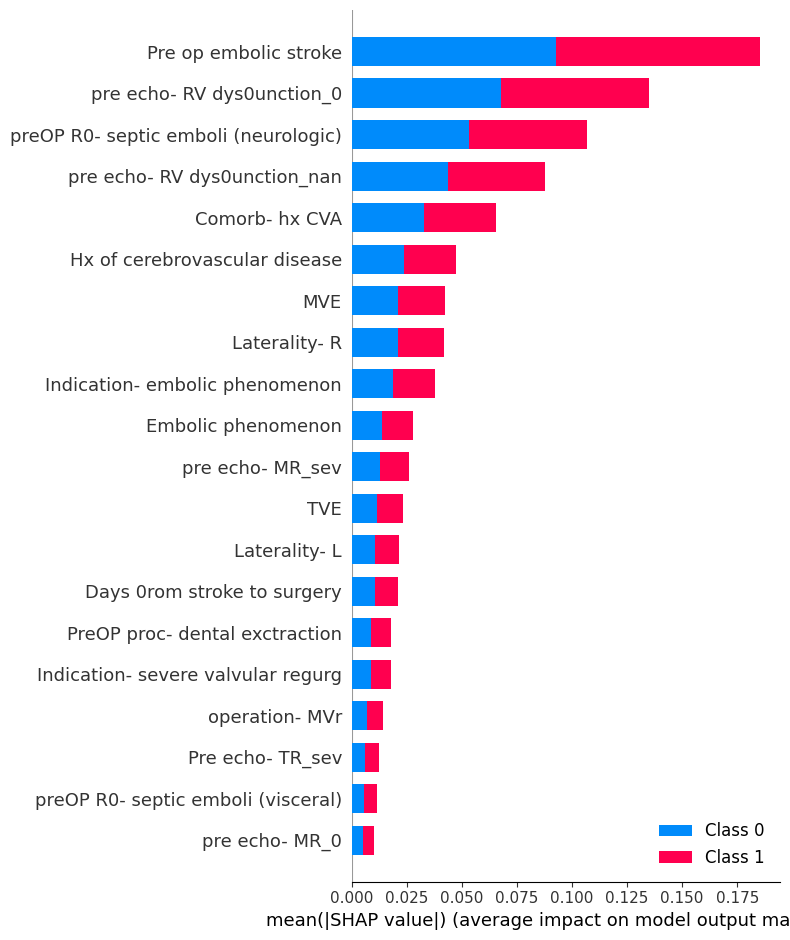

In [71]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline  # This is the import you were missing

# Assuming selected_columns_yes_df1 is your original DataFrame
# and 't5_group' is the target variable

# Define continuous and categorical variables
continuous_vars = selected_columns_yes_df1.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = selected_columns_yes_df1.select_dtypes(include=['object', 'category']).columns

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Define continuous and categorical variables
continuous_vars = selected_columns_yes_df1.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = selected_columns_yes_df1.select_dtypes(include=['object', 'category']).columns

# Define the preprocessing steps for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Bundle preprocessing and modeling code in a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('model', model)
], memory='tmp')

# Split data into train and test sets
X = selected_columns_yes_df1.drop('t5_group', axis=1)
y = selected_columns_yes_df1['t5_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the pipeline with the training data
pipeline.fit(X_train, y_train)

# Access the fitted ColumnTransformer within the pipeline
fitted_preprocessor = pipeline.named_steps['preprocessor']

# Transform the test set
X_test_transformed = fitted_preprocessor.transform(X_test)

# Create the SHAP explainer using the model from the pipeline
explainer = shap.TreeExplainer(pipeline.named_steps['model'])

# Compute SHAP values for the transformed test set
shap_values = explainer.shap_values(X_test_transformed)

# Get the feature names
# Note: The following process depends on the structure of your preprocessor
# Extract feature names for transformed categorical variables
feature_names_transformed = []
for transformer in fitted_preprocessor.transformers_:
    transformer_name, transformer_obj, transformer_cols = transformer
    if transformer_name == 'cat':  # Assuming 'cat' is the name for categorical transformer
        feature_names_transformed.extend(transformer_obj.named_steps['onehot'].get_feature_names_out(transformer_cols))

# Combine with continuous variable names
feature_names = np.concatenate([continuous_vars, feature_names_transformed])

# Plot SHAP values with correct feature names
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type="bar")


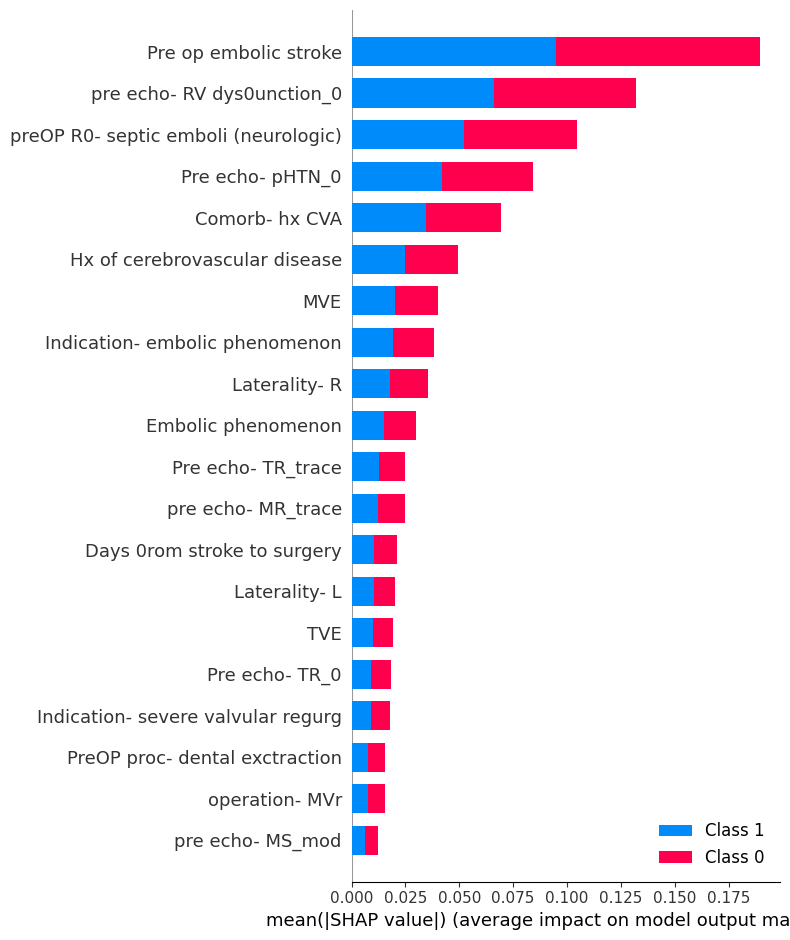

In [73]:
#drop the na and none and re-run model
# Get the feature names for the transformed dataset
feature_names_transformed = []
for transformer in fitted_preprocessor.transformers_:
    transformer_name, transformer_obj, transformer_cols = transformer
    if transformer_name == 'cat':  # Assuming 'cat' is the name for categorical transformer
        feature_names_transformed.extend(transformer_obj.named_steps['onehot'].get_feature_names_out(transformer_cols))

# Combine with continuous variable names
feature_names = np.concatenate([continuous_vars, feature_names_transformed])

# Identify columns to drop (those with '_nan')
columns_to_drop_indices = [i for i, col in enumerate(feature_names) if '_nan' in col]

# Exclude these columns from the dataset used for SHAP value calculation
X_test_transformed_filtered = np.delete(X_test_transformed, columns_to_drop_indices, axis=1)
feature_names_filtered = np.delete(feature_names, columns_to_drop_indices)

# Compute SHAP values for the filtered transformed test set
shap_values_filtered = explainer.shap_values(X_test_transformed_filtered)

# Plot SHAP values with correct feature names, excluding the '_nan' columns
shap.summary_plot(shap_values_filtered, features=X_test_transformed_filtered, feature_names=feature_names_filtered, plot_type="bar")


In [85]:
# Diagnostics: Print shapes and contents of the variables
print("Shape of shap_values_filtered:", np.shape(shap_values_filtered))
print("Shape of mean_abs_shap_values:", np.shape(mean_abs_shap_values))
print("Shape of sorted_indices:", np.shape(sorted_indices))
print("Contents of sorted_feature_names:", sorted_feature_names[:20])


Shape of shap_values_filtered: (2, 89, 351)
Shape of mean_abs_shap_values: (89, 351)
Shape of sorted_indices: (89, 351)
Contents of sorted_feature_names: [['pre echo- TS_sev' 'PreOP proc- pericardiocentesis/window'
  'PreOP proc- Dobhoff' ... 'pre echo- RV dys0unction_0'
  'preOP R0- septic emboli (neurologic)' 'Pre op embolic stroke']
 ['pre echo- TS_sev' 'PreOP RF- GI complication' 'PreOP R0- cirrhosis'
  ... 'preOP R0- septic emboli (neurologic)' 'pre echo- RV dys0unction_0'
  'Pre op embolic stroke']
 ['pre echo- TS_sev' 'operation- AVR tissue' 'PVE' ...
  'preOP R0- septic emboli (neurologic)' 'pre echo- RV dys0unction_0'
  'Pre op embolic stroke']
 ...
 ['pre echo- TS_sev' 'Comorb- Chronic lung disease'
  'Indication- Fungal etiology' ... 'pre echo- RV dys0unction_0'
  'preOP R0- septic emboli (neurologic)' 'Pre op embolic stroke']
 ['pre echo- TS_sev' 'Comorb- Alcoholic hepatitis'
  'Microbe- Cutibacterium acnes' ...
  'preOP R0- septic emboli (neurologic)' 'Pre op embolic strok

In [86]:
# For binary classification, take the SHAP values for the positive class '1'
# which we assume to be the second set in the array (index 1)
shap_values_positive_class = shap_values_filtered[1]

# Now calculate the mean absolute SHAP values for each feature across all samples
mean_abs_shap_values = np.abs(shap_values_positive_class).mean(axis=0)

# Sort the feature names by the mean absolute SHAP values, in descending order
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_feature_names = feature_names_filtered[sorted_indices]

# Now you can get the top features as they are ordered in the SHAP summary plot
top_features_as_in_plot = sorted_feature_names[:20]

print("Top features as displayed in SHAP summary plot:", top_features_as_in_plot)


Top features as displayed in SHAP summary plot: ['Pre op embolic stroke' 'pre echo- RV dys0unction_0'
 'preOP R0- septic emboli (neurologic)' 'Pre echo- pHTN_0'
 'Comorb- hx CVA' 'Hx of cerebrovascular disease' 'MVE'
 'Indication- embolic phenomenon' 'Laterality- R' 'Embolic phenomenon'
 'Pre echo- TR_trace' 'pre echo- MR_trace' 'Days 0rom stroke to surgery'
 'Laterality- L' 'TVE' 'Pre echo- TR_0'
 'Indication- severe valvular regurg' 'PreOP proc- dental exctraction'
 'operation- MVr' 'pre echo- MS_mod']


In [87]:
# Define the list of substrings you want to remove
substrings_to_remove = ['_0', '_mod', '_trace', '_sev']

# Function to remove defined substrings
def remove_substrings(feature_name, substrings):
    for substring in substrings:
        feature_name = feature_name.replace(substring, '')
    return feature_name

# Apply the removal function to each feature name
cleaned_feature_names = [remove_substrings(feature, substrings_to_remove) for feature in top_features_as_in_plot]

print("Cleaned feature names:", cleaned_feature_names)


Cleaned feature names: ['Pre op embolic stroke', 'pre echo- RV dys0unction', 'preOP R0- septic emboli (neurologic)', 'Pre echo- pHTN', 'Comorb- hx CVA', 'Hx of cerebrovascular disease', 'MVE', 'Indication- embolic phenomenon', 'Laterality- R', 'Embolic phenomenon', 'Pre echo- TR', 'pre echo- MR', 'Days 0rom stroke to surgery', 'Laterality- L', 'TVE', 'Pre echo- TR', 'Indication- severe valvular regurg', 'PreOP proc- dental exctraction', 'operation- MVr', 'pre echo- MS']


In [126]:
top_5_features_as_in_plot = sorted_feature_names[:5]
cleaned_5_feature_names = [remove_substrings(feature, substrings_to_remove) for feature in top_5_features_as_in_plot]

print("5 Cleaned feature names:", cleaned_5_feature_names)


5 Cleaned feature names: ['Pre op embolic stroke', 'pre echo- RV dys0unction', 'preOP R0- septic emboli (neurologic)', 'Pre echo- pHTN', 'Comorb- hx CVA']


In [129]:
new_df2= selected_columns_yes_df1[cleaned_5_feature_names]
new_df1 =selected_columns_yes_df1[cleaned_feature_names]
new_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Pre op embolic stroke                 442 non-null    int64  
 1   pre echo- RV dys0unction              442 non-null    object 
 2   preOP R0- septic emboli (neurologic)  442 non-null    int64  
 3   Pre echo- pHTN                        341 non-null    object 
 4   Comorb- hx CVA                        442 non-null    int64  
 5   Hx of cerebrovascular disease         442 non-null    int64  
 6   MVE                                   442 non-null    int64  
 7   Indication- embolic phenomenon        442 non-null    int64  
 8   Laterality- R                         442 non-null    int64  
 9   Embolic phenomenon                    442 non-null    int64  
 10  Pre echo- TR                          415 non-null    object 
 11  pre echo- MR       

array(['Pre op embolic stroke', 'pre echo- RV dys0unction_0',
       'preOP R0- septic emboli (neurologic)', 'Pre echo- pHTN_0',
       'Comorb- hx CVA'], dtype=object)


Logistic Regression:


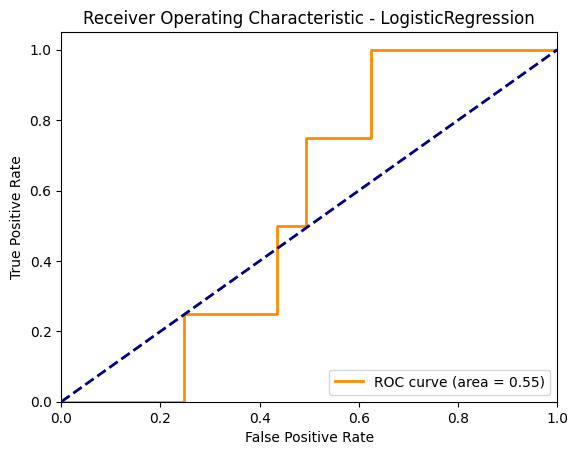


Random Forest:


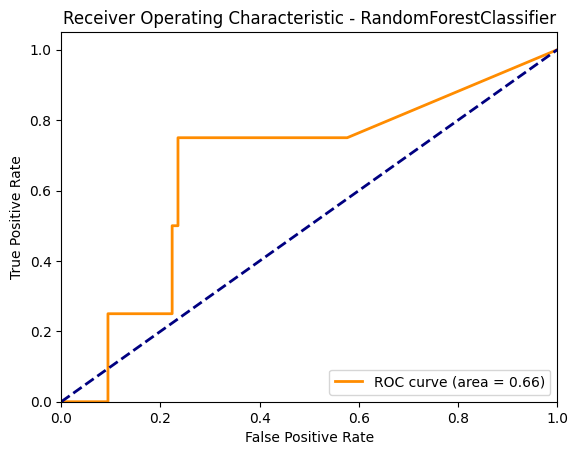


Gradient Boosting:


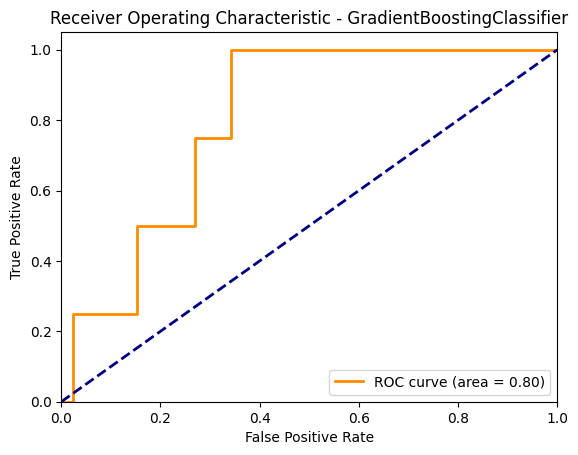

In [115]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap

# Assuming 'new_df1' and 'selected_columns_yes_df' are predefined dataframes
# X = new_df1
y = selected_columns_yes_df['Hospital death']

# Ensure each column in 'X' is unique
X = new_df1.loc[:, ~new_df1.columns.duplicated()]

# Define categorical and continuous variables
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
continuous_vars = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Hospital death']).tolist()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

# Preprocessing for continuous data
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Define classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate a model
def train_eval_model(classifier, X_train, y_train, X_test, y_test):
    # Create and fit the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)

    # Compute ROC-AUC
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {type(classifier).__name__}')
    plt.legend(loc="lower right")
    plt.show()

    return pipeline

# Evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n{name}:")
    model = train_eval_model(clf, X_train, y_train, X_test, y_test)

    # SHAP values (optional, can be computationally intensive)
    # X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
    # explainer = shap.Explainer(model.named_steps['classifier'], X_train_transformed, check_additivity=False)
    # shap_values = explainer(X_train_transformed)
    # shap.summary_plot(shap_values, X_train)


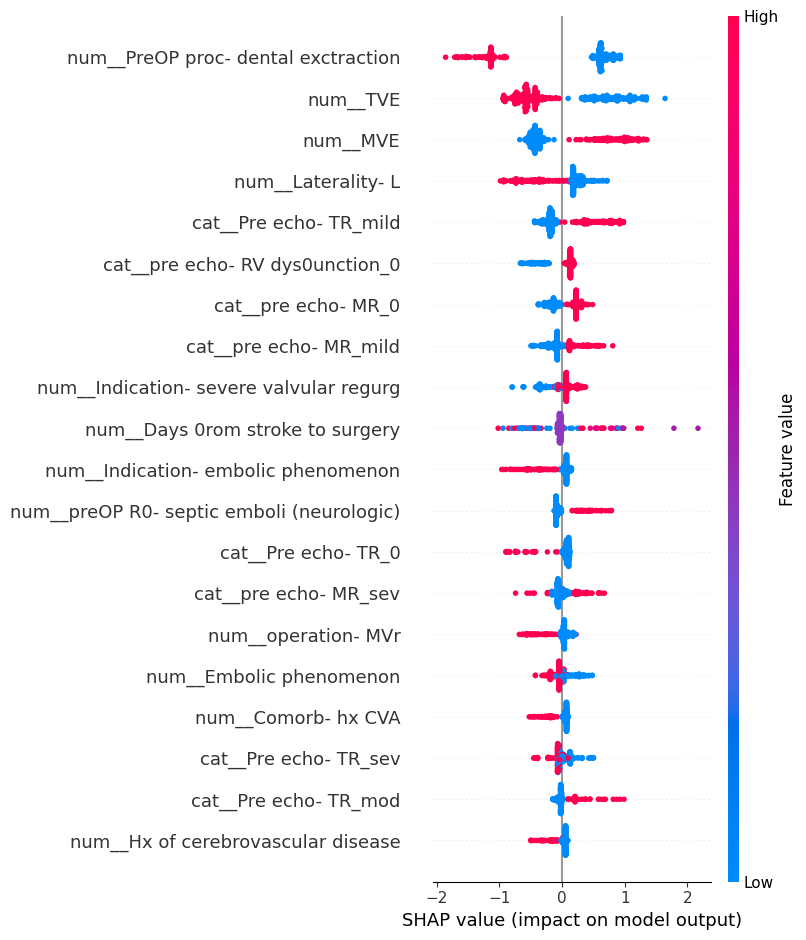

In [119]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# Assuming 'new_df1' and 'selected_columns_yes_df' are your dataframes
y = selected_columns_yes_df['Hospital death']

# Ensure each column in 'X' is unique
X = new_df1.loc[:, ~new_df1.columns.duplicated()]

# Define categorical and continuous variables
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
continuous_vars = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Hospital death']).tolist()

# Preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Create the GradientBoostingClassifier pipeline
gradient_boosting_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Split data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
gradient_boosting_pipeline.fit(X_train, y_train)

# Transform X_train using the preprocessor in the pipeline
X_train_transformed = gradient_boosting_pipeline.named_steps['preprocessor'].transform(X_train)

# SHAP values
explainer = shap.Explainer(gradient_boosting_pipeline.named_steps['classifier'], X_train_transformed)
shap_values = explainer(X_train_transformed)

# Prepare feature names for the plot
feature_names = preprocessor.get_feature_names_out()

# Plot SHAP values summary
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)



Logistic Regression:


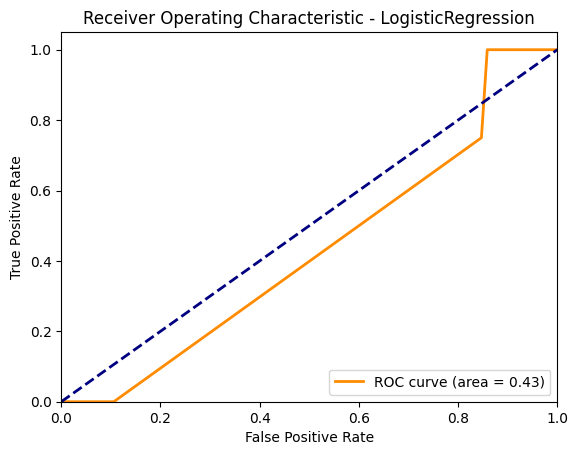


Random Forest:


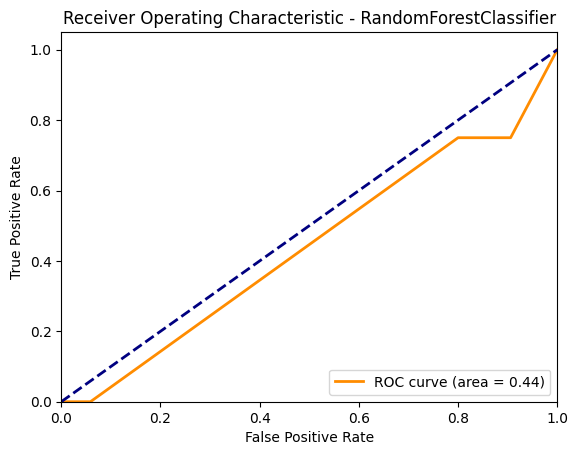


Gradient Boosting:


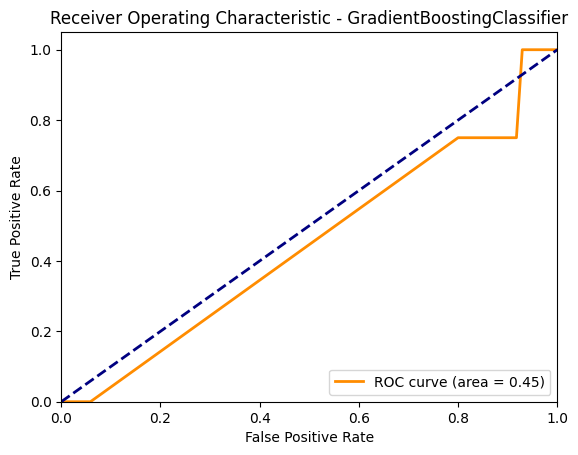

In [133]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap

# Assuming 'new_df2' and 'selected_columns_yes_df' are predefined dataframes
# X = new_df2
y = selected_columns_yes_df['Hospital death']

# Ensure each column in 'X' is unique
X = new_df2.loc[:, ~new_df2.columns.duplicated()]

# Define categorical and continuous variables
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
continuous_vars = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Hospital death']).tolist()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

# Preprocessing for continuous data
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Define classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate a model
def train_eval_model(classifier, X_train, y_train, X_test, y_test):
    # Create and fit the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)

    # Compute ROC-AUC
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {type(classifier).__name__}')
    plt.legend(loc="lower right")
    plt.show()

    return pipeline

# Evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n{name}:")
    model = train_eval_model(clf, X_train, y_train, X_test, y_test)

    # SHAP values (optional, can be computationally intensive)
    # X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
    # explainer = shap.Explainer(model.named_steps['classifier'], X_train_transformed, check_additivity=False)
    # shap_values = explainer(X_train_transformed)
    # shap.summary_plot(shap_values, X_train)


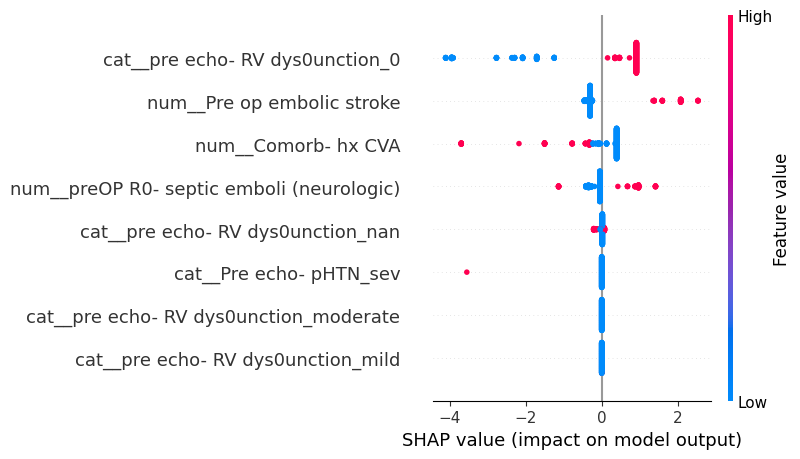

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# Assuming 'new_df2' and 'selected_columns_yes_df' are your dataframes
y = selected_columns_yes_df['Hospital death']

# Ensure each column in 'X' is unique
X = new_df2.loc[:, ~new_df2.columns.duplicated()]

# Define categorical and continuous variables
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
continuous_vars = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Hospital death']).tolist()

# Preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ])

# Create the GradientBoostingClassifier pipeline
gradient_boosting_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Split data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
gradient_boosting_pipeline.fit(X_train, y_train)

# Transform X_train using the preprocessor in the pipeline
X_train_transformed = gradient_boosting_pipeline.named_steps['preprocessor'].transform(X_train)

# SHAP values
explainer = shap.Explainer(gradient_boosting_pipeline.named_steps['classifier'], X_train_transformed)
shap_values = explainer(X_train_transformed)

# Prepare feature names for the plot
feature_names = preprocessor.get_feature_names_out()

# Plot SHAP values summary
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


In [135]:
#to write file to html
import nbformat
from nbconvert import HTMLExporter

# Load your notebook
with open("large_language_model_selected_variables_dec_4rth_2023.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Convert to HTML
exporter = HTMLExporter()
body, _ = exporter.from_notebook_node(nb)

# Write the HTML to a file
with open("large_language_model_selected_variables_dec_4rth_updated_2023.html", "w") as f:
    f.write(body)
